Hello! We are going to use a chunk of Sloan Digital Sky Survey's data here. Our aim is to build some machine learning model to classify galaxies/stars/quasars based on their spectral properties. After that we will also consider differnt metrics to assess those models' performance.

First thing first. Let's import some mandatory modules and packages.

In [335]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
from matplotlib import pyplot as plt
from matplotlib import style
import numpy as np
import os
import pandas as pd
import seaborn as sns
style.use(style='seaborn-deep')
from tabulate import tabulate
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import lightgbm as lgb 
from lightgbm import LGBMClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
from sklearn.metrics import ConfusionMatrixDisplay
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from yellowbrick.classifier import ROCAUC
from yellowbrick.style import set_palette

Accessing the dataset..............

In [336]:
sdss_df = pd.read_csv('star_classification.csv')

Let's check some basic info about the dataset.

In [337]:
sdss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

So, there are 100,000 entries or rows and 18 columns in total.

In [338]:
print("The shape of the dataset: {}".format(sdss_df.shape))

The shape of the dataset: (100000, 18)


In [339]:
classes = sdss_df['class'].unique()
print(classes)

['GALAXY' 'QSO' 'STAR']


In [340]:
sdss_df

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.240000e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.540000e+18,GALAXY,0.634794,5812,56354,171
1,1.240000e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.180000e+19,GALAXY,0.779136,10445,58158,427
2,1.240000e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.150000e+18,GALAXY,0.644195,4576,55592,299
3,1.240000e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030000e+19,GALAXY,0.932346,9149,58039,775
4,1.240000e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.890000e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.240000e+18,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.060000e+19,GALAXY,0.000000,9374,57749,438
99996,1.240000e+18,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.590000e+18,GALAXY,0.404895,7626,56934,866
99997,1.240000e+18,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.110000e+18,GALAXY,0.143366,2764,54535,74
99998,1.240000e+18,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.600000e+18,GALAXY,0.455040,6751,56368,470


Let's check if there is any null value.

In [341]:
sdss_df.isnull().sum()

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64


All okay! No null value. Amazing!


In [342]:
sdss_df['class'].value_counts()

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

So, in our dataset there are 59445 galaxies, 21594 star, and 18961 QSOs. Now we can plot the Histogramof the classes. Here it is......

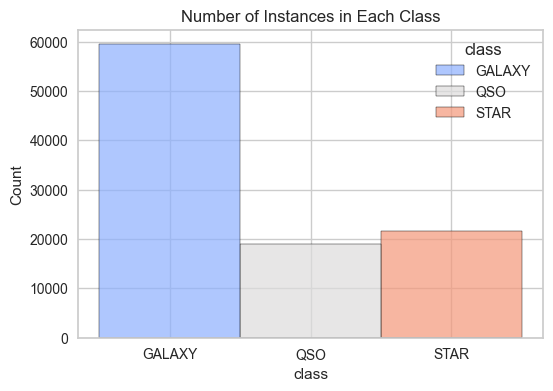

In [343]:
plt.figure(figsize=(6, 4))
sns.histplot(data=sdss_df, x='class', hue='class', alpha=.7, palette='coolwarm')
plt.title('Number of Instances in Each Class')
plt.show()

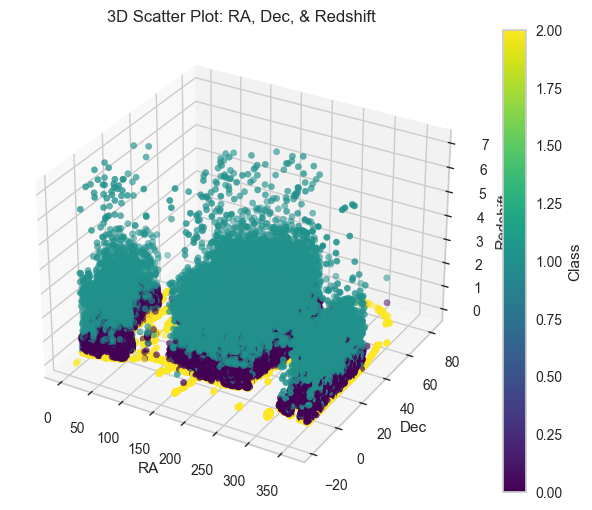

In [344]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
sdss_df['class_rep'] = le.fit_transform(sdss_df['class'])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(sdss_df['alpha'], sdss_df['delta'], sdss_df['redshift'], c=sdss_df['class_rep'], cmap='viridis')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_zlabel('Redshift')
ax.set_title('3D Scatter Plot: RA, Dec, & Redshift')

# Adding color bar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Class')

plt.show()


In [345]:
sdss_all_var=sdss_df.drop(['class_rep','class'], axis=1)

Now, we will check the features' correlations.

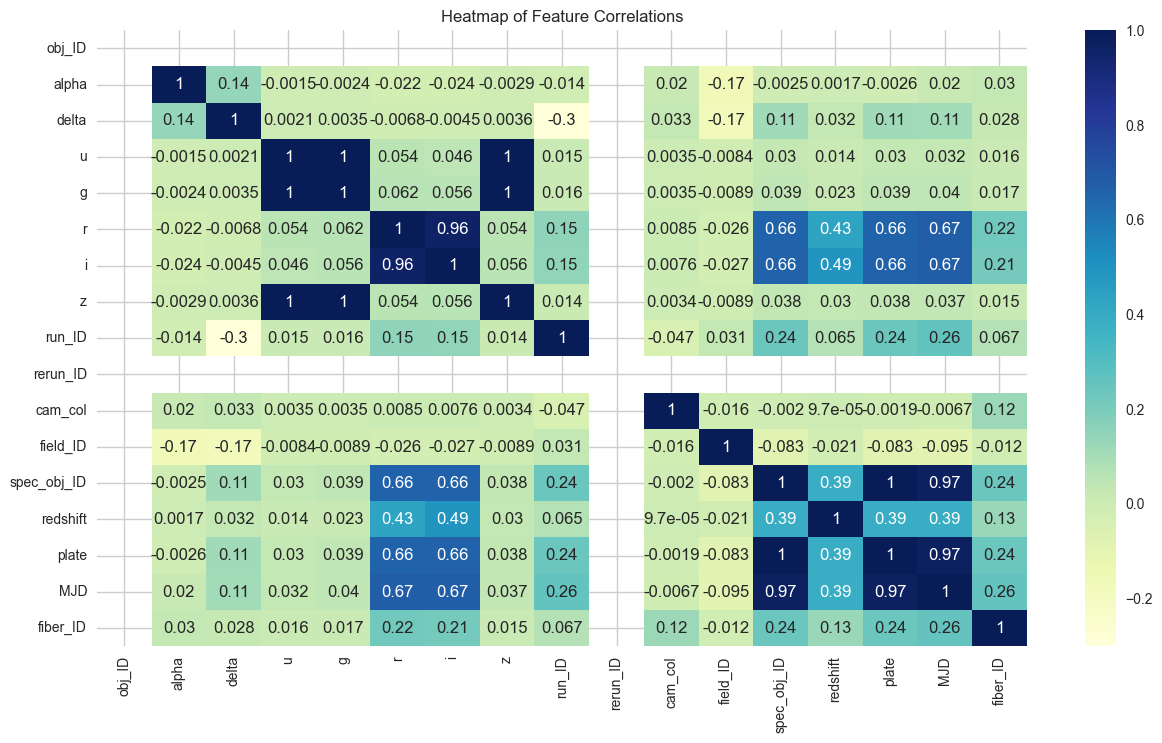

In [346]:
plt.figure(figsize=(15, 8))
sns.heatmap(sdss_all_var.corr(), annot=True, cmap="YlGnBu")
plt.title('Heatmap of Feature Correlations')
# Define the path to save the plot as a PNG file
save_path = r'C:\Users\DELL\Downloads\ml_paper\heatmap.png'

# Save the plot as a PNG file
plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

At this point, we exclude columns that solely represent distinct identification numbers. Additionally, we remove MJD since it serves as a time indicator, and cam_col, which is unrelated to class distinctions. From our domain knowledge we know that alpha and delta have also should not have any effect on the classification. 

In [347]:
sdss_imp=sdss_df.drop(['alpha', 'delta','obj_ID','run_ID','rerun_ID','cam_col','field_ID','spec_obj_ID','plate','MJD','fiber_ID', 'class_rep'], axis=1)
imp_columns = [ 'u', 'g', 'r', 'i', 'z', 'redshift']

In [348]:
sdss_imp

,u,g,r,i,z,class,redshift
0,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794
1,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136
2,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195
3,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346
4,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123
...,...,...,...,...,...,...,...
99995,22.16759,22.97586,21.90404,21.30548,20.73569,GALAXY,0.000000
99996,22.69118,22.38628,20.45003,19.75759,19.41526,GALAXY,0.404895
99997,21.16916,19.26997,18.20428,17.69034,17.35221,GALAXY,0.143366
99998,25.35039,21.63757,19.91386,19.07254,18.62482,GALAXY,0.455040


Let's visulaize the new column reduced dataset. 

In [349]:
def plot_boxplots(data_frame, analysis_columns, target_column):
    """
    This function generates boxplots for analyzing the distribution of data.

    Params:
    `data_frame`: DataFrame containing the dataset.
    `analysis_columns`: List of columns to analyze.
    `target_column`: Name of the target column.

    Returns:
    None
    """
    # Create a figure with appropriate size
    plt.figure(figsize=(15, 30))

    # Calculate the number of columns for subplots
    num_columns = len(analysis_columns)

    # Loop through the analysis columns
    for i, column in enumerate(analysis_columns):
        # Create a subplot for each feature
        plt.subplot(int('{}2{}'.format(num_columns, i+1)))

        # Generate a boxplot for the current feature
        sns.boxplot(x=target_column, y=column, data=data_frame, width=0.5, flierprops={'marker': 'x'})

        # Set the title for the boxplot
        plt.title(label='Boxplot of {}'.format(column), fontsize=10)

        # Remove x and y labels to avoid clutter
        plt.xlabel(xlabel=None)
        plt.ylabel(ylabel=None)

    # Display the boxplots
    plt.show()

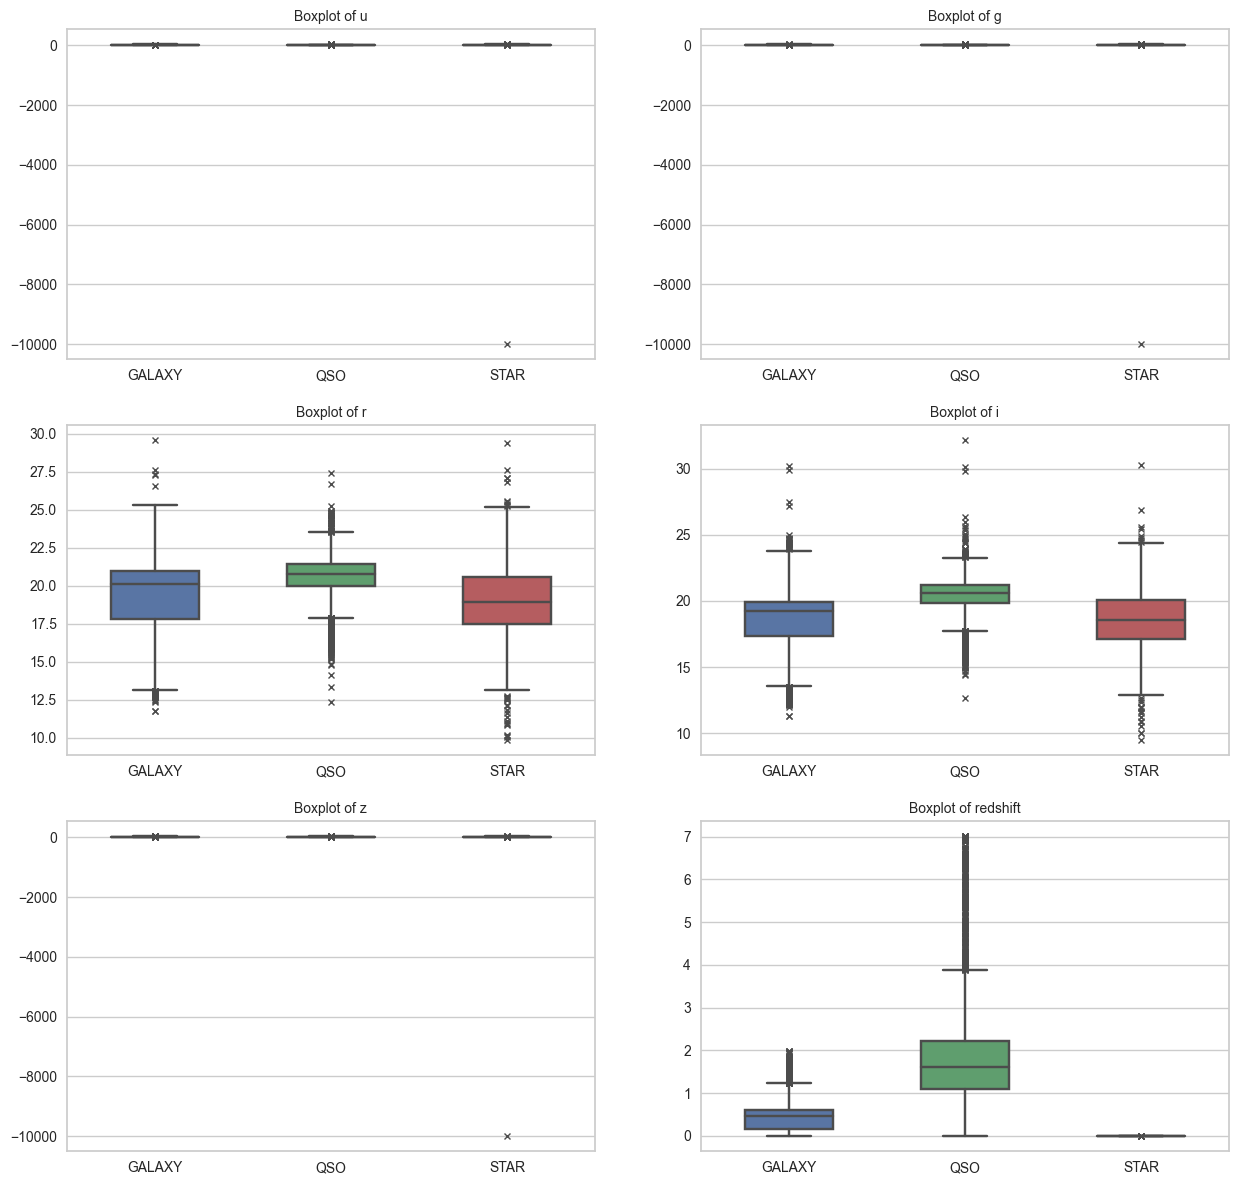

In [350]:
plot_boxplots(data_frame=sdss_imp, analysis_columns=imp_columns, target_column='class')

We can see that in case of the 'u', 'g', 'z' boxplots there are negative values. These values are obviously some kind of errors or outliers.  We have to get rid of these negative values as part of feature engineering.

In [351]:
display(sdss_imp[sdss_imp['u'] <0])

,u,g,r,i,z,class,redshift
79543,-9999.0,-9999.0,18.1656,18.01675,-9999.0,STAR,0.000089


In [352]:
display(sdss_imp[sdss_imp['g'] <0])

,u,g,r,i,z,class,redshift
79543,-9999.0,-9999.0,18.1656,18.01675,-9999.0,STAR,0.000089


In [353]:
display(sdss_imp[sdss_imp['z'] <0])

,u,g,r,i,z,class,redshift
79543,-9999.0,-9999.0,18.1656,18.01675,-9999.0,STAR,0.000089


In all the cases only the 70543 no. row contain negative values. Let's remove it. 

In [354]:
sdss_imp = sdss_imp.drop(index=[79543])

In [355]:
print("New shape: {}".format(sdss_imp.shape))

New shape: (99999, 7)


We will boxplot again

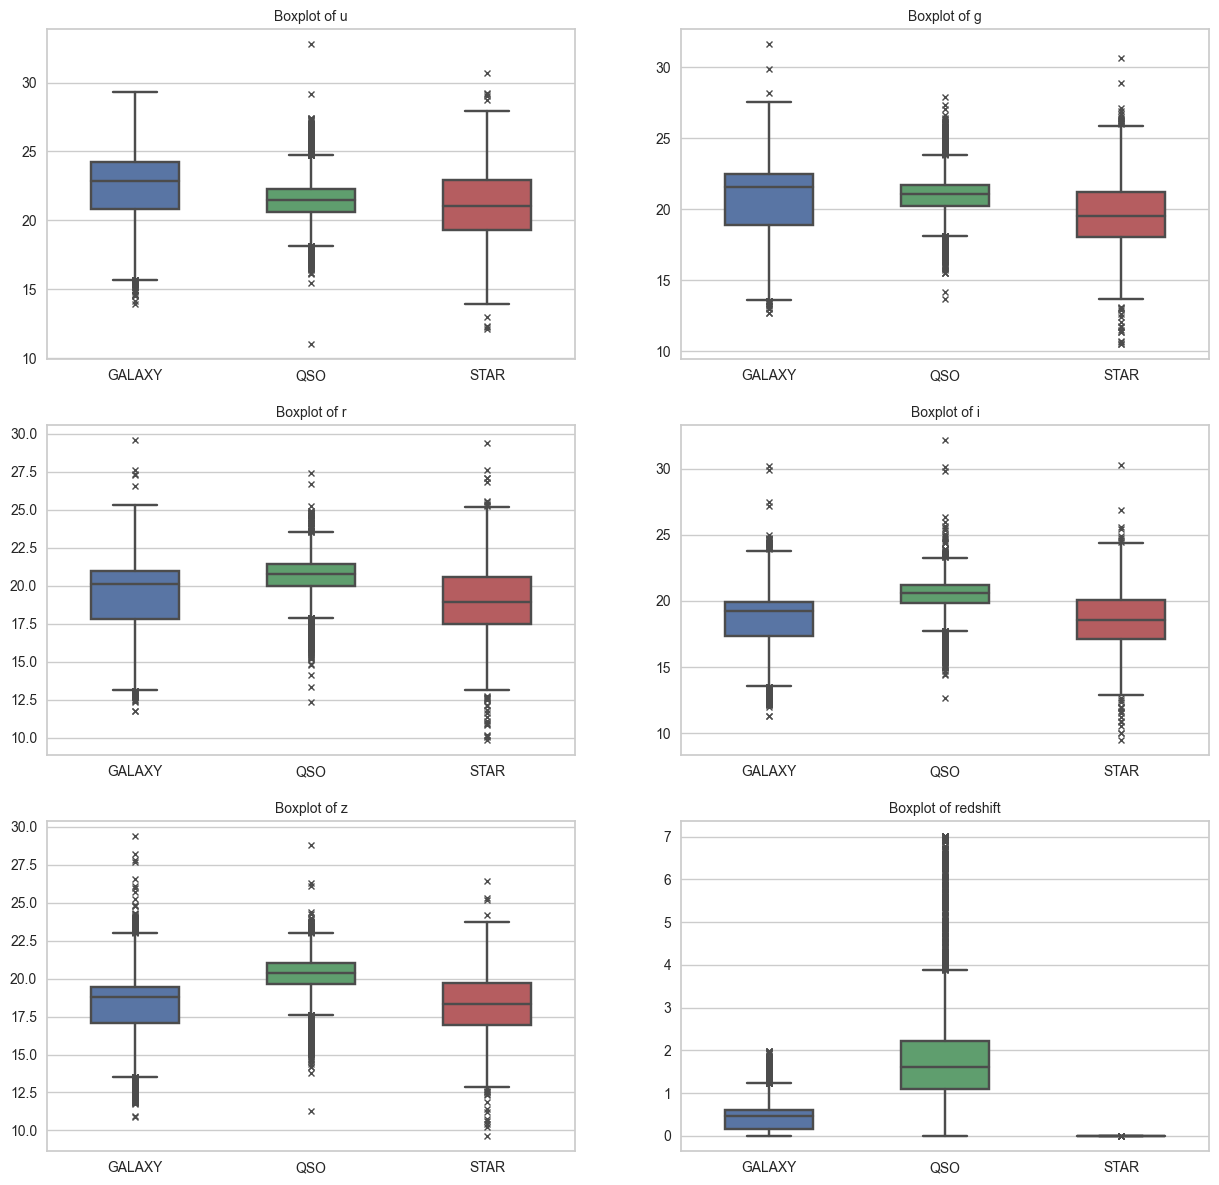

In [356]:
plot_boxplots(data_frame=sdss_imp, analysis_columns=imp_columns, target_column='class')

Now the boxplots are looking much better!!

Now, we will check the correlations of the important features' with each other.

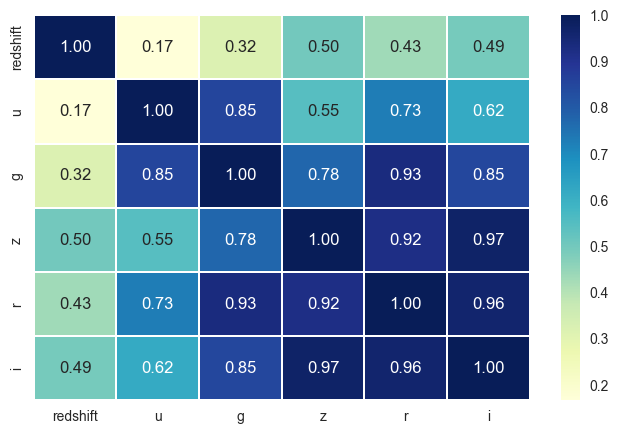

In [357]:
plt.figure(figsize=(8, 5))
sns.heatmap(data=sdss_imp[[ 'redshift','u', 'g', 'z', 'r', 'i']].corr(),
            annot=True, fmt='.2f', linewidths=0.1, cmap="YlGnBu")
plt.show()

Before excluding the row '79543' there were some correlations value equal to 1. But after eliminating that row, the new heatmap has no correlation value equal to 1.

In [358]:
X = sdss_imp[imp_columns]
y = sdss_imp['class'].values
print("X shape: {}".format(X.shape))
print("y shape: {}".format(y.shape))

X shape: (99999, 6)
y shape: (99999,)


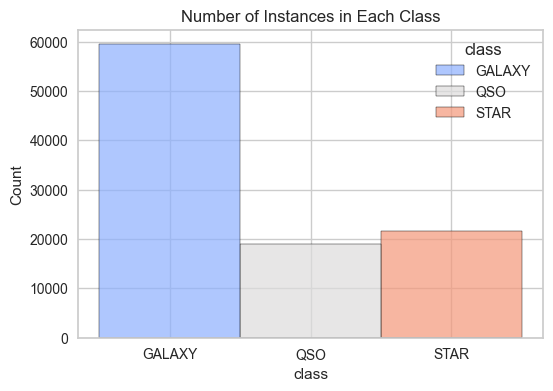

In [359]:
plt.figure(figsize=(6, 4))
sns.histplot(data=sdss_imp, x='class', hue='class', alpha=.7, palette='coolwarm')
plt.title('Number of Instances in Each Class')
plt.show()

From this histogram we can see that the three different classes in the dataset are very imbalanced. The amount of QSOs and stars are somewhat comparable, but the number of galaxies are almost 3 times than any other classification type. 

This is a very big issue. This phenomenon can create biases towards galaxy classification in our model. So, we need to treat this problem very carefully. To rescue ourselves there is a package called SMOTE function. This function is employed to address the issue of imbalanced datasets by creating artificial instances (dummy instances) of the minority class through interpolation based on existing minority class data points. 

In [360]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

In [361]:
from collections import Counter
print(Counter(y))

Counter({'GALAXY': 59445, 'QSO': 59445, 'STAR': 59445})


We standardized our dataset using the StandardScaler module provided by the scikit-learn library.

In [362]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
stdscal = StandardScaler()
X = stdscal.fit_transform(X)
le = LabelEncoder()
y = le.fit_transform(y)
print(le.classes_)
print(X)
print(y)
sdss_imp['class'] = le.fit_transform(sdss_imp['class'])

['GALAXY' 'QSO' 'STAR']
[[ 0.9787894   0.91976676  0.37028242 -0.06163149 -0.12370325 -0.08587325]
 [ 1.39479162  1.20552305  1.57026624  1.0672832   1.44833554  0.07218198]
 [ 1.61949956  1.11927454  0.4879827   0.04145071 -0.03755926 -0.07557925]
 ...
 [-1.30056964 -1.7926897  -2.10111253 -2.20925649 -2.23187216 -0.78178907]
 [ 0.18374298  0.00292935  0.20631057  0.36939554  0.4893328  -0.78067578]
 [-0.12261271 -0.71847042 -1.16370433 -1.75148474 -2.00942122 -0.78106406]]
[0 0 0 ... 2 2 2]


Now We intend to divide our ultimate dataset into a 0.3 ratio, with 70% allocated for training data and 30% for testing data.

In [363]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [364]:
classifiers = [
    RandomForestClassifier(),
    ExtraTreesClassifier(),
    GaussianNB(),
    DecisionTreeClassifier(),
    LogisticRegression(),
    SVC(),
    AdaBoostClassifier(),
    KNeighborsClassifier(),
    BaggingClassifier(),
    GradientBoostingClassifier(),
    MLPClassifier(),
    XGBClassifier(),
    SGDClassifier(),
    QuadraticDiscriminantAnalysis(),
    LGBMClassifier() 
]
highest_model = None
highest_accuracy = 0
from sklearn.pipeline import make_pipeline
for classifier in classifiers:
    pipeline = make_pipeline(StandardScaler(), classifier)
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)

    if accuracy > highest_accuracy:
        highest_accuracy = accuracy
        highest_model = classifier.__class__.__name__

    print(f"{classifier.__class__.__name__} - accuracy: {accuracy}")
    
print(f"The best performing model is: {highest_model} with accuracy: {highest_accuracy}")

RandomForestClassifier - accuracy: 0.9819816452028934
ExtraTreesClassifier - accuracy: 0.982990972131362
GaussianNB - accuracy: 0.9203940113268911
DecisionTreeClassifier - accuracy: 0.9709351227079868
LogisticRegression - accuracy: 0.9494215061400721
SVC - accuracy: 0.9644305713911889
AdaBoostClassifier - accuracy: 0.45916898749556084
KNeighborsClassifier - accuracy: 0.9698697220612699
BaggingClassifier - accuracy: 0.9800564475430366
GradientBoostingClassifier - accuracy: 0.9702809293284238
MLPClassifier - accuracy: 0.9727668641707632
XGBClassifier - accuracy: 0.9782807797985085
SGDClassifier - accuracy: 0.912524999532719
QuadraticDiscriminantAnalysis - accuracy: 0.9499074783648904
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 124834, number of used features: 6
[LightGBM] [Info] St

In our primary evaluation the best performing model is ExtraTreesClassifier with accuracy 98.15%. RandomForestClassifier, BaggingClassifier, XGBClassifier, Light BGM Classifier and MLPClassifier are the 2nd, 3rd, 4th, 5th and 6th best performing model respectively. 

0.9820190276817256
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     17877
           1       0.98      0.97      0.97     17601
           2       1.00      1.00      1.00     18023

    accuracy                           0.98     53501
   macro avg       0.98      0.98      0.98     53501
weighted avg       0.98      0.98      0.98     53501

Accuracy using Random Forest Classifier(random_state=42): 0.9820190276817256


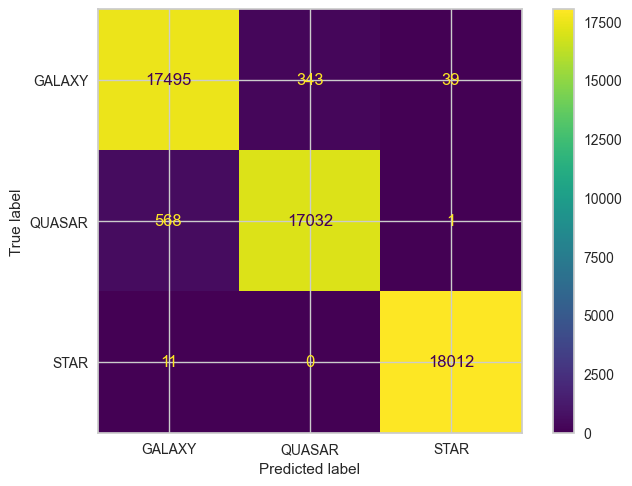

In [365]:
from sklearn.metrics import ConfusionMatrixDisplay
from mlxtend.plotting import plot_confusion_matrix

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_predict = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_predict)
print(accuracy)


ConfusionMatrixDisplay.from_predictions(y_test, y_predict, 
                                        display_labels = ['GALAXY', 'QUASAR', 'STAR'])


cr1 = classification_report(y_test, y_predict)
print(cr1)
accuracy_rfc = rfc.score(X_test, y_test)
print("Accuracy using Random Forest Classifier(random_state=42):", accuracy_rfc)

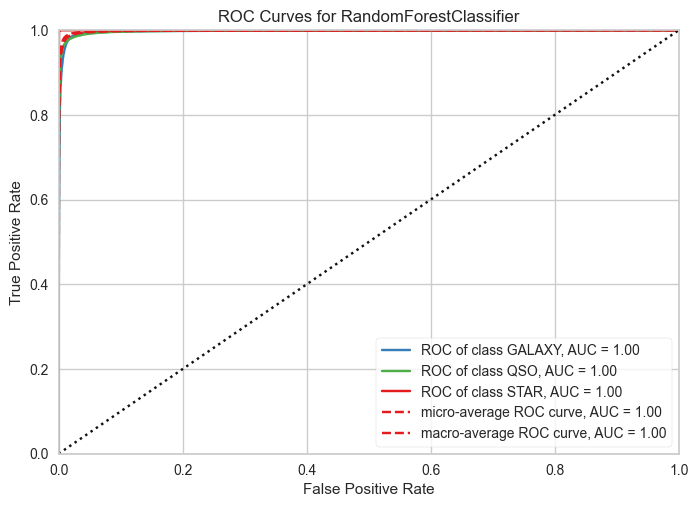

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [366]:
from yellowbrick.classifier import ROCAUC
from yellowbrick.style import set_palette
roc_rfc = ROCAUC(rfc, classes=classes)
set_palette('bold')
roc_rfc.fit(X_train, y_train)        
roc_rfc.score(X_test, y_test)       
roc_rfc.show() 

We will now proceed with the hyperparameter tuning process for RandomForests by employing RandomizedSearchCV.

In [367]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'max_depth': [None, 10, 20, 30],
    'bootstrap': [True, False]
}
random_search_rf = RandomizedSearchCV(estimator=rfc, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150, 200]},
                   random_state=42)

In [368]:
print("Best Estimator:", random_search_rf.best_estimator_)
print("Best Parameters RF:", random_search_rf.best_params_)

Best Estimator: RandomForestClassifier(bootstrap=False, max_depth=30, min_samples_split=5,
                       n_estimators=50, random_state=42)
Best Parameters RF: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': False}


0.9827853684977851
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     17877
           1       0.98      0.97      0.98     17601
           2       1.00      1.00      1.00     18023

    accuracy                           0.98     53501
   macro avg       0.98      0.98      0.98     53501
weighted avg       0.98      0.98      0.98     53501

Accuracy using optimized RFC: 0.9827853684977851


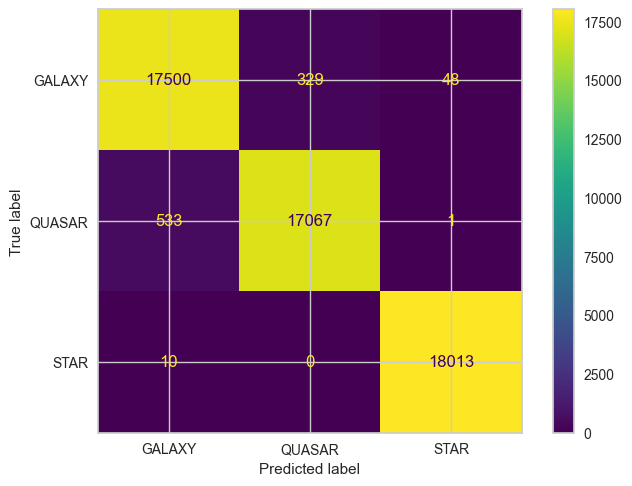

In [369]:
best_rf_model = random_search_rf.best_estimator_
best_rf_model.get_params
best_rf_model.fit(X_train, y_train)
y_predict = best_rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_predict)
print(accuracy)

ConfusionMatrixDisplay.from_predictions(y_test, y_predict, 
                                        display_labels = ['GALAXY', 'QUASAR', 'STAR'])

cr1 = classification_report(y_test, y_predict)
print(cr1)
accuracy_best_rf_model = best_rf_model.score(X_test, y_test)
print("Accuracy using optimized RFC:", accuracy_best_rf_model)

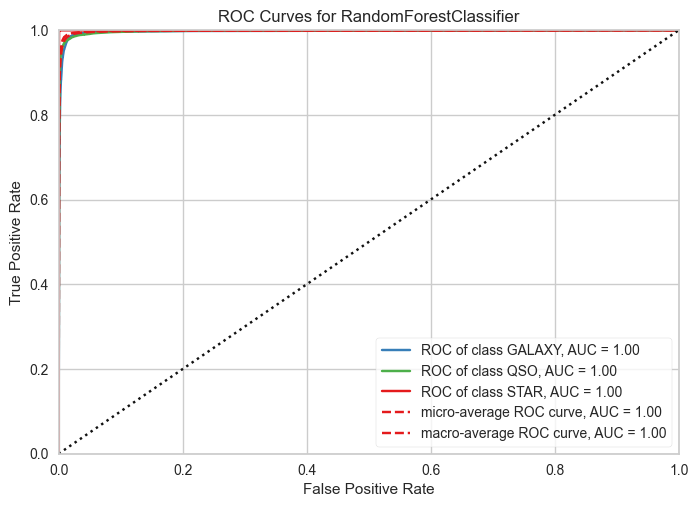

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [370]:
roc_rfc_tuned = ROCAUC(best_rf_model, classes=classes)
set_palette('bold')
roc_rfc_tuned.fit(X_train, y_train)        
roc_rfc_tuned.score(X_test, y_test)       
roc_rfc_tuned.show() 

In [371]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'n_estimators': [10, 25, 50],
    'min_samples_split': [5],
    'min_samples_leaf': [1],
    'max_depth': [30, 40, 50, 60],
    'bootstrap': [False]
}
random_search_rf = RandomizedSearchCV(estimator=rfc, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [False],
                                        'max_depth': [30, 40, 50, 60],
                                        'min_samples_leaf': [1],
                                        'min_samples_split': [5],
                                        'n_estimators': [10, 25, 50]},
                   random_state=42)

In [372]:
print("Best Estimator:", random_search_rf.best_estimator_)
print("Best Parameters RF:", random_search_rf.best_params_)

Best Estimator: RandomForestClassifier(bootstrap=False, max_depth=50, min_samples_split=5,
                       n_estimators=50, random_state=42)
Best Parameters RF: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 50, 'bootstrap': False}


0.9828975159342817
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     17877
           1       0.98      0.97      0.98     17601
           2       1.00      1.00      1.00     18023

    accuracy                           0.98     53501
   macro avg       0.98      0.98      0.98     53501
weighted avg       0.98      0.98      0.98     53501

Accuracy using optimized (Tuned) RFC: 0.9828975159342817


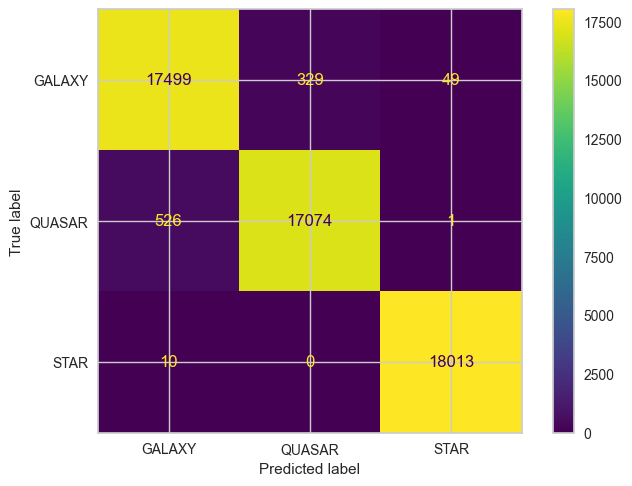

In [373]:
best_rf_model = random_search_rf.best_estimator_
best_rf_model.get_params
best_rf_model.fit(X_train, y_train)
y_predict = best_rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_predict)
print(accuracy)

ConfusionMatrixDisplay.from_predictions(y_test, y_predict, 
                                        display_labels = ['GALAXY', 'QUASAR', 'STAR'])

cr1 = classification_report(y_test, y_predict)
print(cr1)
accuracy_best_rf_model = best_rf_model.score(X_test, y_test)
print("Accuracy using optimized (Tuned) RFC:", accuracy_best_rf_model)

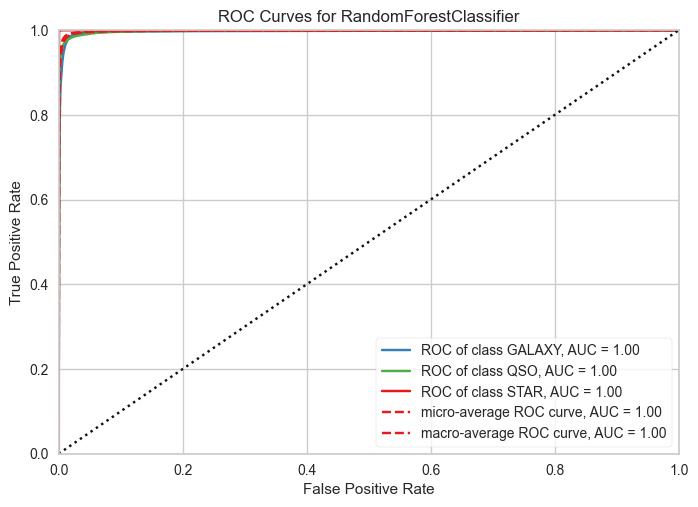

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [374]:
roc_rfc_tuned = ROCAUC(best_rf_model, classes=classes)
set_palette('bold')
roc_rfc_tuned.fit(X_train, y_train)        
roc_rfc_tuned.score(X_test, y_test)       
roc_rfc_tuned.show() 

We will now proceed with the hyperparameter tuning process for ExtraTreesClassifier by employing RandomizedSearchCV.

0.9824676174277116
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     17877
           1       0.98      0.97      0.98     17601
           2       0.99      1.00      1.00     18023

    accuracy                           0.98     53501
   macro avg       0.98      0.98      0.98     53501
weighted avg       0.98      0.98      0.98     53501

Accuracy using Extra Trees Classifier(random_state=42): 0.9824676174277116


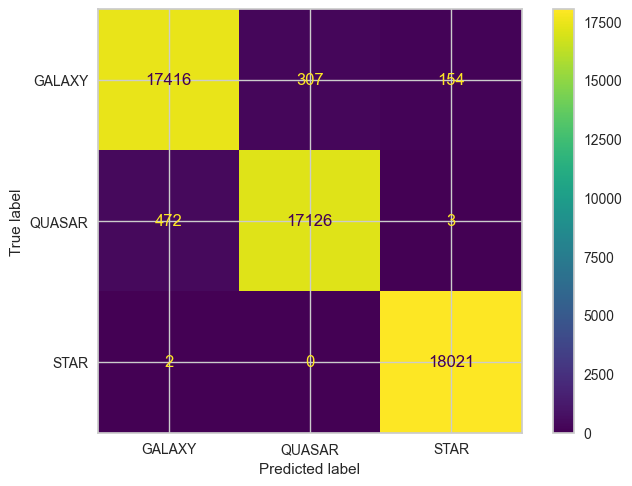

In [375]:
from sklearn.metrics import ConfusionMatrixDisplay

etc = ExtraTreesClassifier(random_state=42)
etc.fit(X_train, y_train)
y_predict = etc.predict(X_test)
accuracy = accuracy_score(y_test, y_predict)
print(accuracy)


ConfusionMatrixDisplay.from_predictions(y_test, y_predict, 
                                        display_labels = ['GALAXY', 'QUASAR', 'STAR'])


cr1 = classification_report(y_test, y_predict)
print(cr1)
accuracy_etc = etc.score(X_test, y_test)
print("Accuracy using Extra Trees Classifier(random_state=42):", accuracy_etc)

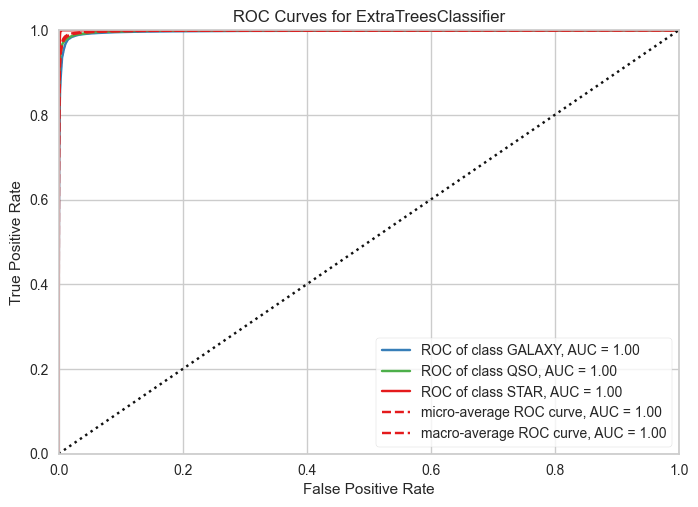

<Axes: title={'center': 'ROC Curves for ExtraTreesClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [376]:
roc_etc = ROCAUC(etc, classes=classes)
set_palette('bold')
roc_etc.fit(X_train, y_train)        
roc_etc.score(X_test, y_test)       
roc_etc.show() 

In [377]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'warm_start': [True, False],
    'n_estimators': [10,50,100],
    'max_features': ['auto','sqrt','log2'], 
    'max_depth': [2,8,16,32,50],   
    'bootstrap': [True, False]
}

random_search_etc = RandomizedSearchCV(estimator=etc, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search_etc.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=ExtraTreesClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 8, 16, 32, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [10, 50, 100],
                                        'warm_start': [True, False]},
                   random_state=42)

In [378]:
print("Best Estimator:", random_search_etc.best_estimator_)
print("Best Parameters ETC:", random_search_etc.best_params_)

Best Estimator: ExtraTreesClassifier(max_depth=32, n_estimators=50, random_state=42)
Best Parameters ETC: {'warm_start': False, 'n_estimators': 50, 'max_features': 'sqrt', 'max_depth': 32, 'bootstrap': False}


0.9818694977663969
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     17877
           1       0.98      0.97      0.98     17601
           2       0.99      1.00      1.00     18023

    accuracy                           0.98     53501
   macro avg       0.98      0.98      0.98     53501
weighted avg       0.98      0.98      0.98     53501

Accuracy using Extra Trees Classifier (Tuned): 0.9818694977663969


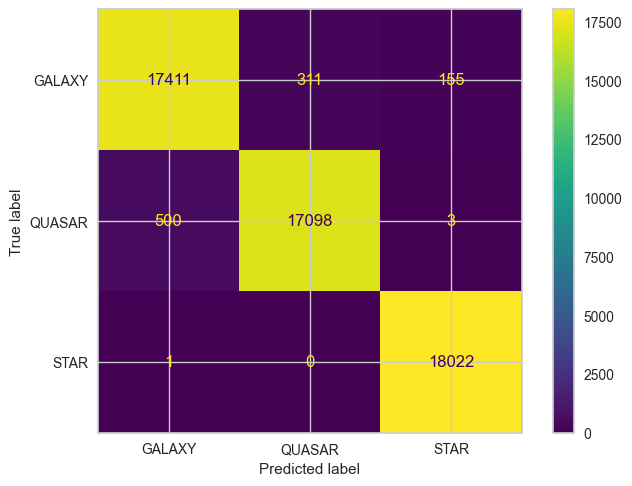

In [379]:
best_etc_model = random_search_etc.best_estimator_
best_etc_model.get_params
best_etc_model.fit(X_train, y_train)
y_predict = best_etc_model.predict(X_test)

accuracy = accuracy_score(y_test, y_predict)
print(accuracy)

ConfusionMatrixDisplay.from_predictions(y_test, y_predict, 
                                        display_labels = ['GALAXY', 'QUASAR', 'STAR'])

cr1 = classification_report(y_test, y_predict)
print(cr1)
accuracy_best_etc_model = best_etc_model.score(X_test, y_test)
print("Accuracy using Extra Trees Classifier (Tuned):", accuracy_best_etc_model)


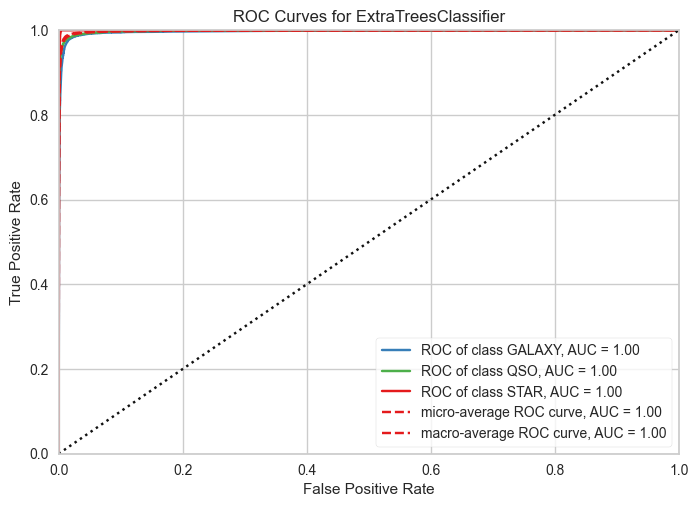

<Axes: title={'center': 'ROC Curves for ExtraTreesClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [380]:
roc_etc_tuned = ROCAUC(best_etc_model, classes=classes)
set_palette('bold')
roc_etc_tuned.fit(X_train, y_train)        
roc_etc_tuned.score(X_test, y_test)       
roc_etc_tuned.show() 

In the case of Extra Trees Classifier, the primary model has given the best accuracy. 

We will now proceed with the hyperparameter tuning process for BaggingClassifier by employing RandomizedSearchCV.

0.9800190650642044
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     17877
           1       0.98      0.96      0.97     17601
           2       1.00      1.00      1.00     18023

    accuracy                           0.98     53501
   macro avg       0.98      0.98      0.98     53501
weighted avg       0.98      0.98      0.98     53501

Accuracy using Bagging Classifier(random_state=42): 0.9800190650642044


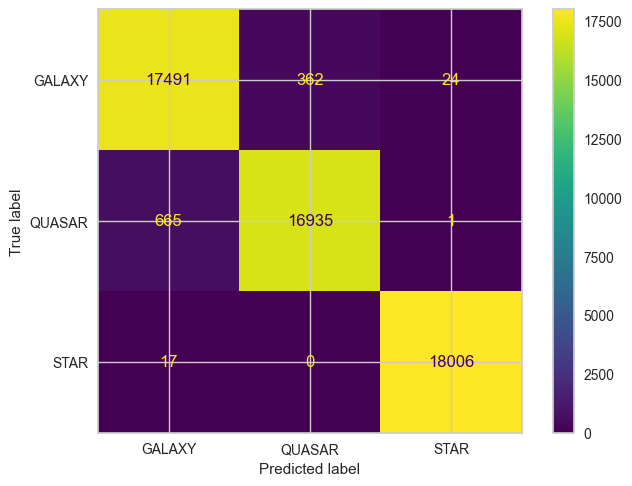

In [381]:
bc = BaggingClassifier(random_state=42)
bc.fit(X_train, y_train)
y_predict = bc.predict(X_test)
accuracy = accuracy_score(y_test, y_predict)
print(accuracy)

ConfusionMatrixDisplay.from_predictions(y_test, y_predict, 
                                        display_labels = ['GALAXY', 'QUASAR', 'STAR'])

cr1 = classification_report(y_test, y_predict)
print(cr1)
accuracy_bc = bc.score(X_test, y_test)
print("Accuracy using Bagging Classifier(random_state=42):", accuracy_bc)

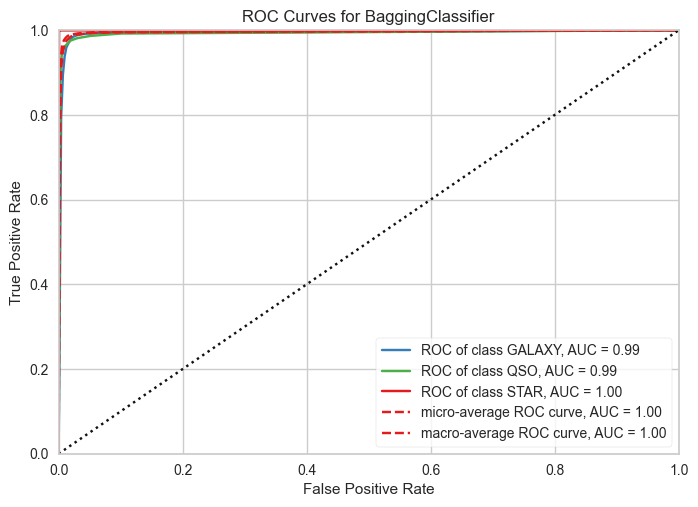

<Axes: title={'center': 'ROC Curves for BaggingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [382]:
roc_bc = ROCAUC(bc, classes=classes)
set_palette('bold')
roc_bc.fit(X_train, y_train)        
roc_bc.score(X_test, y_test)       
roc_bc.show() 

In [383]:
param_dist = {
    'warm_start': [True, False],
    'oob_score': [True, False],
    'n_estimators': [25, 50, 100, 150, 200],
    'max_samples' : [0.05, 0.1, 0.2, 0.5],
    'max_features': [0.90, 0.92, 0.95, 1.0],
    'bootstrap_features': [True, False],
    'bootstrap': [True, False]
    
}
random_search_bc = RandomizedSearchCV(estimator=bc, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search_bc.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=BaggingClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'bootstrap_features': [True, False],
                                        'max_features': [0.9, 0.92, 0.95, 1.0],
                                        'max_samples': [0.05, 0.1, 0.2, 0.5],
                                        'n_estimators': [25, 50, 100, 150, 200],
                                        'oob_score': [True, False],
                                        'warm_start': [True, False]},
                   random_state=42)

In [384]:
print("Best Estimator:", random_search_bc.best_estimator_)
print("Best Parameters BC:", random_search_bc.best_params_)

Best Estimator: BaggingClassifier(max_features=0.92, max_samples=0.5, n_estimators=50,
                  random_state=42, warm_start=True)
Best Parameters BC: {'warm_start': True, 'oob_score': False, 'n_estimators': 50, 'max_samples': 0.5, 'max_features': 0.92, 'bootstrap_features': False, 'bootstrap': True}


0.9796826227547148
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     17877
           1       0.98      0.96      0.97     17601
           2       1.00      1.00      1.00     18023

    accuracy                           0.98     53501
   macro avg       0.98      0.98      0.98     53501
weighted avg       0.98      0.98      0.98     53501

Accuracy using Bagging Classifier: 0.9796826227547148


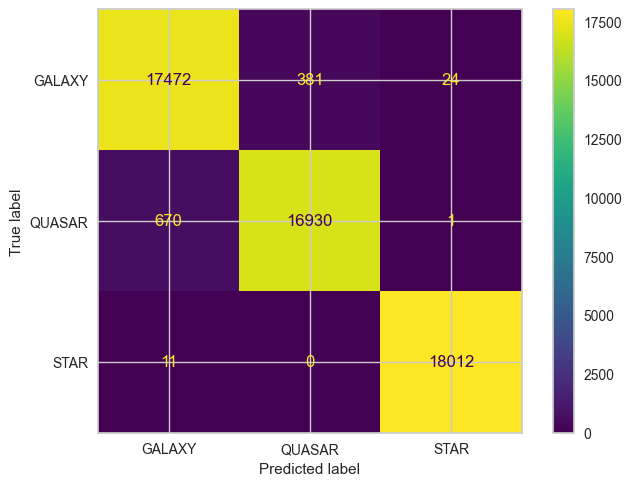

In [385]:
best_bc_model = random_search_bc.best_estimator_
best_bc_model.get_params
best_bc_model.fit(X_train, y_train)
y_predict = best_bc_model.predict(X_test)

accuracy = accuracy_score(y_test, y_predict)
print(accuracy)

ConfusionMatrixDisplay.from_predictions(y_test, y_predict, 
                                        display_labels = ['GALAXY', 'QUASAR', 'STAR'])

cr1 = classification_report(y_test, y_predict)
print(cr1)
accuracy_best_bc_model = best_bc_model.score(X_test, y_test)
print("Accuracy using Bagging Classifier:", accuracy_best_bc_model)


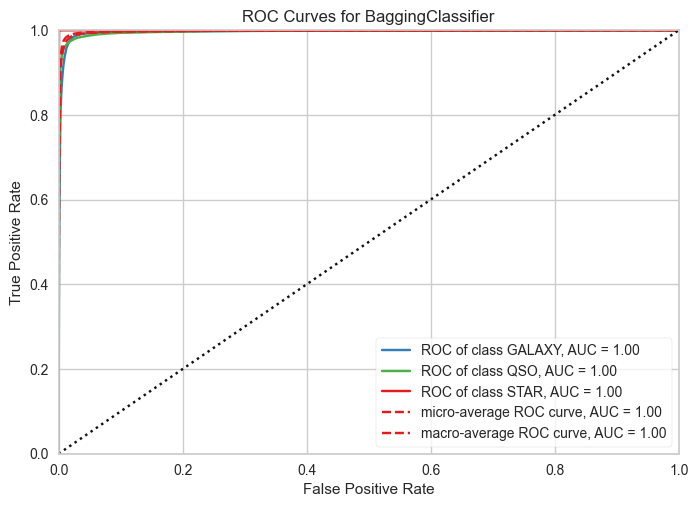

<Axes: title={'center': 'ROC Curves for BaggingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [386]:
roc_bc_tuned = ROCAUC(best_bc_model, classes=classes)
set_palette('bold')
roc_bc_tuned.fit(X_train, y_train)        
roc_bc_tuned.score(X_test, y_test)       
roc_bc_tuned.show() 

 We will now proceed with the hyperparameter tuning process for MLPClassifier by employing RandomizedSearchCV.

0.9728977028466758
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     17877
           1       0.97      0.96      0.96     17601
           2       0.99      1.00      0.99     18023

    accuracy                           0.97     53501
   macro avg       0.97      0.97      0.97     53501
weighted avg       0.97      0.97      0.97     53501

Accuracy using MLPClassifier (random_state=42): 0.9728977028466758


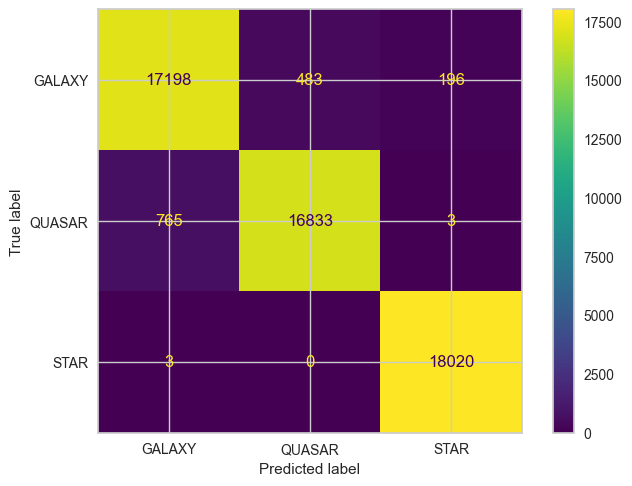

In [387]:
mlp = MLPClassifier(random_state=42)
mlp.fit(X_train, y_train)
y_predict = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_predict)
print(accuracy)

ConfusionMatrixDisplay.from_predictions(y_test, y_predict, 
                                        display_labels = ['GALAXY', 'QUASAR', 'STAR'])

cr1 = classification_report(y_test, y_predict)
print(cr1)
accuracy_mlp = mlp.score(X_test, y_test)
print("Accuracy using MLPClassifier (random_state=42):", accuracy_mlp)

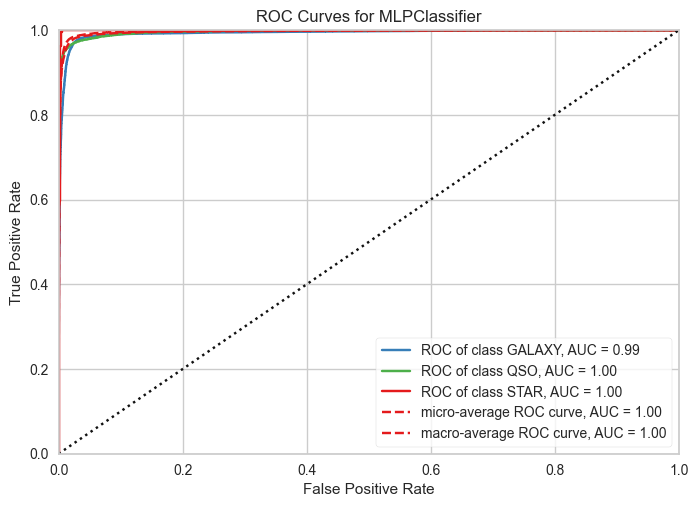

<Axes: title={'center': 'ROC Curves for MLPClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [388]:
roc_mlp = ROCAUC(mlp, classes=classes)
set_palette('bold')
roc_mlp.fit(X_train, y_train)        
roc_mlp.score(X_test, y_test)       
roc_mlp.show() 

In [389]:
param_dist = {
    'solver': ['sgd', 'adam', 'lbfgs'],
    'learning_rate': ['constant','adaptive'],
    'hidden_layer_sizes': [(10,30,10), (50,50,50), (20,)],
    'alpha': [0.0001, 0.05, 0.9],
    'activation': ['tanh', 'relu', 'logistic']
    


}

random_search_mlp = RandomizedSearchCV(estimator=mlp, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search_mlp.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=MLPClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'activation': ['tanh', 'relu',
                                                       'logistic'],
                                        'alpha': [0.0001, 0.05, 0.9],
                                        'hidden_layer_sizes': [(10, 30, 10),
                                                               (50, 50, 50),
                                                               (20,)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'solver': ['sgd', 'adam', 'lbfgs']},
                   random_state=42)

In [390]:
print("Best Estimator:", random_search_mlp.best_estimator_)
print("Best Parameters MLP:", random_search_mlp.best_params_)

Best Estimator: MLPClassifier(hidden_layer_sizes=(10, 30, 10), random_state=42)
Best Parameters MLP: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (10, 30, 10), 'alpha': 0.0001, 'activation': 'relu'}


0.9715706248481337
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     17877
           1       0.97      0.95      0.96     17601
           2       0.99      1.00      0.99     18023

    accuracy                           0.97     53501
   macro avg       0.97      0.97      0.97     53501
weighted avg       0.97      0.97      0.97     53501

Accuracy using MLP Classifier (Tuned): 0.9715706248481337


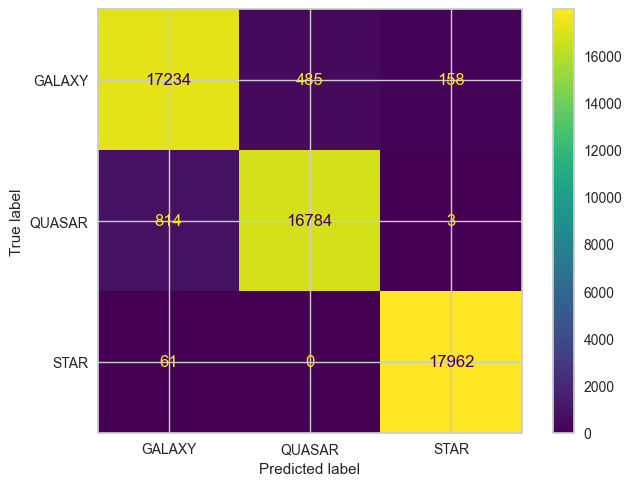

In [391]:
best_mlp_model = random_search_mlp.best_estimator_
best_mlp_model.get_params
best_mlp_model.fit(X_train, y_train)
y_predict = best_mlp_model.predict(X_test)

accuracy = accuracy_score(y_test, y_predict)
print(accuracy)

ConfusionMatrixDisplay.from_predictions(y_test, y_predict, 
                                        display_labels = ['GALAXY', 'QUASAR', 'STAR'])

cr1 = classification_report(y_test, y_predict)
print(cr1)
accuracy_best_mlp_model = best_mlp_model.score(X_test, y_test)
print("Accuracy using MLP Classifier (Tuned):", accuracy_best_mlp_model)


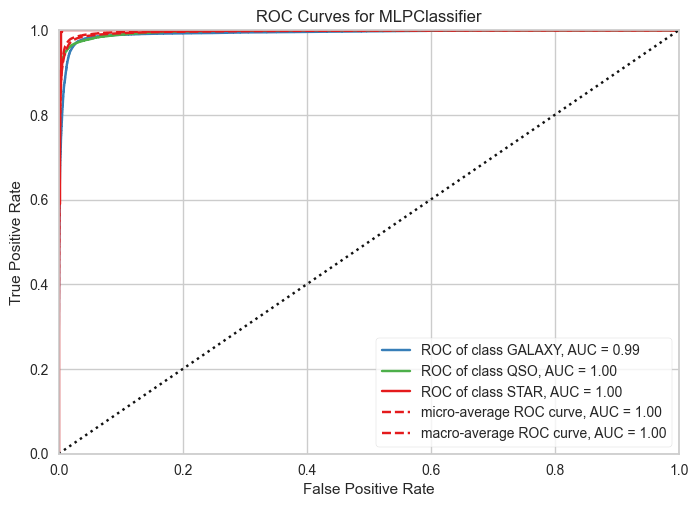

<Axes: title={'center': 'ROC Curves for MLPClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [392]:
roc_mlp_tuned = ROCAUC(best_mlp_model, classes=classes)
set_palette('bold')
roc_mlp_tuned.fit(X_train, y_train)        
roc_mlp_tuned.score(X_test, y_test)       
roc_mlp_tuned.show() 

In the case of MLPClassifier, the primary model has given the best accuracy. 

We will now proceed with the hyperparameter tuning process for XGBClassifier by employing RandomizedSearchCV.

0.9782620885590924
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     17877
           1       0.98      0.96      0.97     17601
           2       1.00      1.00      1.00     18023

    accuracy                           0.98     53501
   macro avg       0.98      0.98      0.98     53501
weighted avg       0.98      0.98      0.98     53501

Accuracy using XGBClassifier (random_state=42): 0.9782620885590924


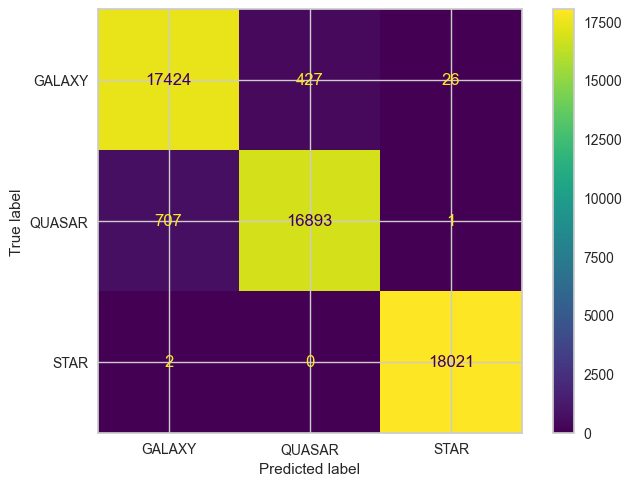

In [393]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_predict = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_predict)
print(accuracy)

ConfusionMatrixDisplay.from_predictions(y_test, y_predict, 
                                        display_labels = ['GALAXY', 'QUASAR', 'STAR'])

cr1 = classification_report(y_test, y_predict)
print(cr1)
accuracy_xgb = xgb.score(X_test, y_test)
print("Accuracy using XGBClassifier (random_state=42):", accuracy_xgb)

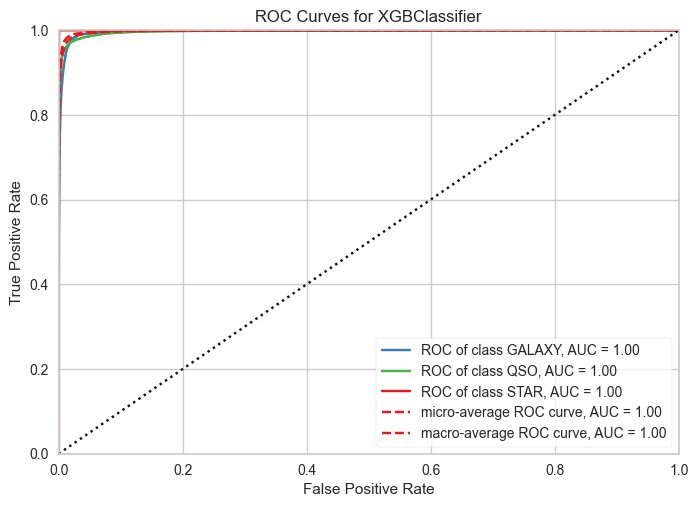

<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [394]:
roc_xgb = ROCAUC(xgb, classes=classes)
set_palette('bold')
roc_xgb.fit(X_train, y_train)        
roc_xgb.score(X_test, y_test)       
roc_xgb.show() 

In [395]:
param_dist = {
    'subsample': [0.001, 0.3, 0.5, 0.6, 0.7],
    'n_estimators': [100, 500, 1000, 2000],
    'min_child_weight' : [ 0.5, 1,2, 3],
    'max_depth' : [ 3, 4, 5, 6], 
    'learning_rate' : [0.01, 0.01,0.03, 0.05],  
    'gamma': [ 0.0, 0.1, 0.2 ,0.25 ], 
    'colsample_bytree' : [ 0.3, 0.4, 0.5 ,0.6]
    



}
random_search_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           objective='multi:softprob',
                                           predictor=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.6],
                                        'gamma': [0.0, 0.1, 0.2, 0.25],
                                        'learning_rate': [0.01, 0.01, 0.03,
                                                          0.05],
                                        'max_depth': [3, 4, 5, 6],
                                        'min_child_weight': [0.5, 1, 2, 3],
                                        'n_estimators': [100, 500, 1000, 2000],
                                        'subsample': [0.001, 0.3, 0.5, 0.6,
                                                      0.7]},
                   random_state=42)

In [396]:
print("Best Estimator:", random_search_xgb.best_estimator_)
print("Best Parameters:", random_search_xgb.best_params_)

Best Estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=0.5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)
Best Parameters: {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 0.5, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.0, 'colsample_bytree': 0.5}


0.9731033064802527
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     17877
           1       0.97      0.95      0.96     17601
           2       1.00      1.00      1.00     18023

    accuracy                           0.97     53501
   macro avg       0.97      0.97      0.97     53501
weighted avg       0.97      0.97      0.97     53501

Accuracy using XGBClassifier (Tuned): 0.9731033064802527


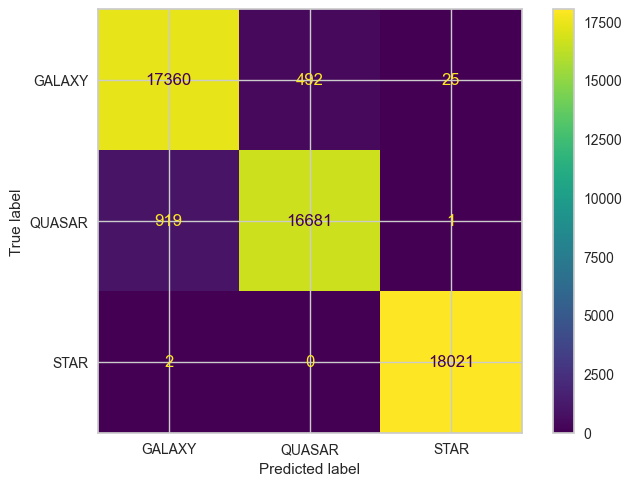

In [397]:
best_xgb_model = random_search_xgb.best_estimator_
best_xgb_model.get_params
best_xgb_model.fit(X_train, y_train)
y_predict = best_xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_predict)
print(accuracy)

ConfusionMatrixDisplay.from_predictions(y_test, y_predict, 
                                        display_labels = ['GALAXY', 'QUASAR', 'STAR'])

cr1 = classification_report(y_test, y_predict)
print(cr1)
accuracy_best_xgb_model = best_xgb_model.score(X_test, y_test)
print("Accuracy using XGBClassifier (Tuned):", accuracy_best_xgb_model)

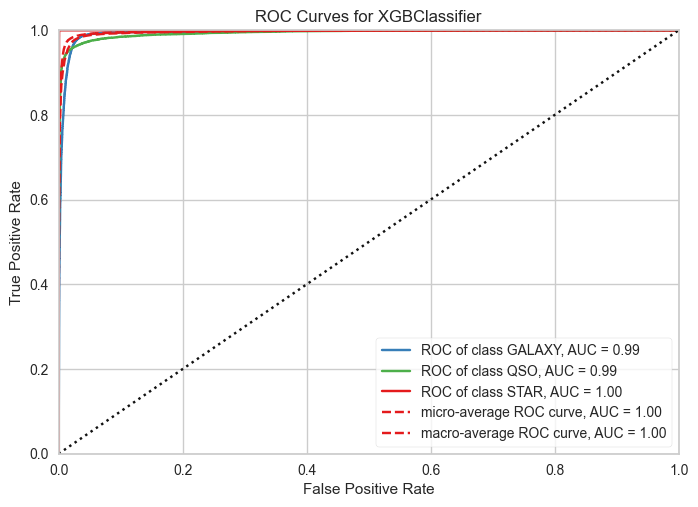

<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [398]:
roc_xgb_tuned = ROCAUC(best_xgb_model, classes=classes)
set_palette('bold')
roc_xgb_tuned.fit(X_train, y_train)        
roc_xgb_tuned.score(X_test, y_test)       
roc_xgb_tuned.show() 

In [399]:
param_dist = {
    'subsample': [0.6],
    'n_estimators': [100],
    'min_child_weight' : [ 0.5],
    'max_depth' : [5], 
    'learning_rate' : [0.05,0.10,0.15,0.20, 0.25,0.30,0.6],  
    'gamma': [ 0.0 ], 
    'colsample_bytree' : [  0.5]

#Best Parameters XGB: {'subsample': 0.3, 'n_estimators': 2000, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.5}

}
random_search_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           objective='multi:softprob',
                                           predictor=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5],
                                        'gamma': [0.0],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3, 0.6],
                                        'max_depth': [5],
                                        'min_child_weight': [0.5],
                                        'n_estimators': [100],
                                        'subsample': [0.6]},
                   random_state=42)

In [400]:
print("Best Estimator:", random_search_xgb.best_estimator_)
print("Best Parameters XGB:", random_search_xgb.best_params_)

Best Estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=0.5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)
Best Parameters XGB: {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 0.5, 'max_depth': 5, 'learning_rate': 0.3, 'gamma': 0.0, 'colsample_bytree': 0.5}


0.9765238032933964
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     17877
           1       0.97      0.96      0.96     17601
           2       1.00      1.00      1.00     18023

    accuracy                           0.98     53501
   macro avg       0.98      0.98      0.98     53501
weighted avg       0.98      0.98      0.98     53501

Accuracy using XGBClassifier (Tuned): 0.9765238032933964


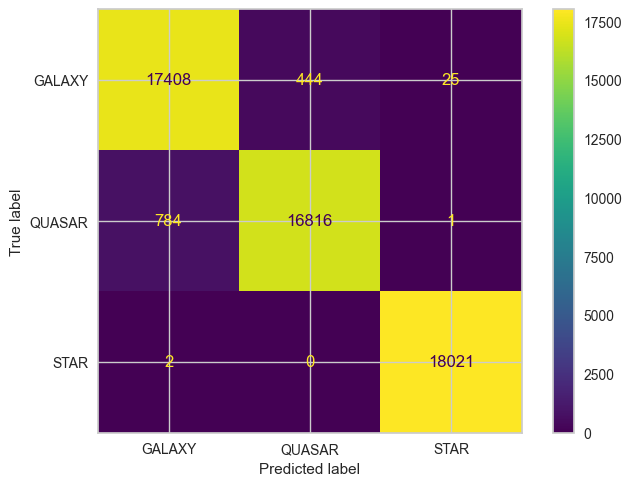

In [401]:
best_xgb_model = random_search_xgb.best_estimator_
best_xgb_model.get_params
best_xgb_model.fit(X_train, y_train)
y_predict = best_xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_predict)
print(accuracy)

ConfusionMatrixDisplay.from_predictions(y_test, y_predict, 
                                        display_labels = ['GALAXY', 'QUASAR', 'STAR'])

cr1 = classification_report(y_test, y_predict)
print(cr1)
accuracy_best_xgb_model = best_xgb_model.score(X_test, y_test)
print("Accuracy using XGBClassifier (Tuned):", accuracy_best_xgb_model)

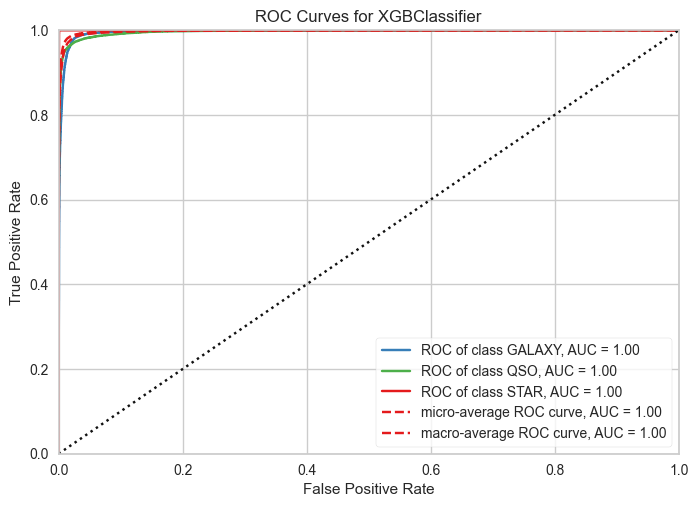

<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [402]:
roc_xgb_tuned = ROCAUC(best_xgb_model, classes=classes)
set_palette('bold')
roc_xgb_tuned.fit(X_train, y_train)        
roc_xgb_tuned.score(X_test, y_test)       
roc_xgb_tuned.show() 

In the case of XGBClassifier, the primary model has given the best accuracy. 

Let's see the case for LightGBM Classifier. We will now proceed with the hyperparameter tuning process for LightGBM Classifier by employing RandomizedSearchCV.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 124834, number of used features: 6
[LightGBM] [Info] Start training from score -1.099654
[LightGBM] [Info] Start training from score -1.093036
[LightGBM] [Info] Start training from score -1.103173
0.9757013887590886
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     17877
           1       0.98      0.96      0.97     17601
           2       1.00      1.00      1.00     18023

    accuracy                           0.98     53501
   macro avg       0.98      0.98      0.98     53501
weighted avg       0.98      0.98      0.98     53501

Accuracy using LGBM Classifier(random_state=42): 0.9757013887590886


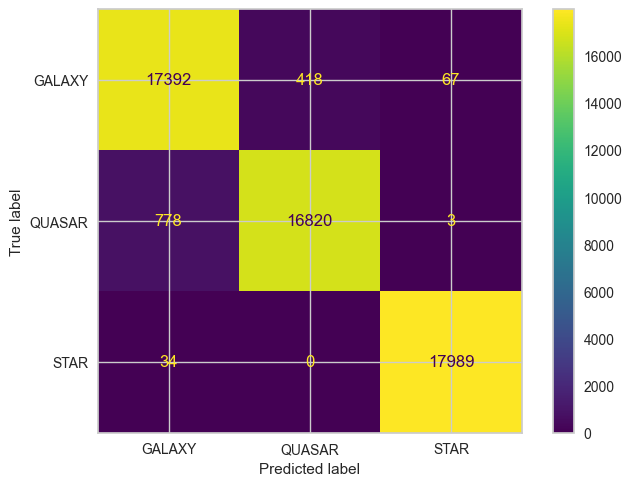

In [403]:
import lightgbm as lgb 
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)
y_predict = lgbm.predict(X_test)
accuracy = accuracy_score(y_test, y_predict)
print(accuracy)

ConfusionMatrixDisplay.from_predictions(y_test, y_predict, 
                                        display_labels = ['GALAXY', 'QUASAR', 'STAR'])

cr1 = classification_report(y_test, y_predict)
print(cr1)
accuracy_lgbm = lgbm.score(X_test, y_test)
print("Accuracy using LGBM Classifier(random_state=42):", accuracy_lgbm)

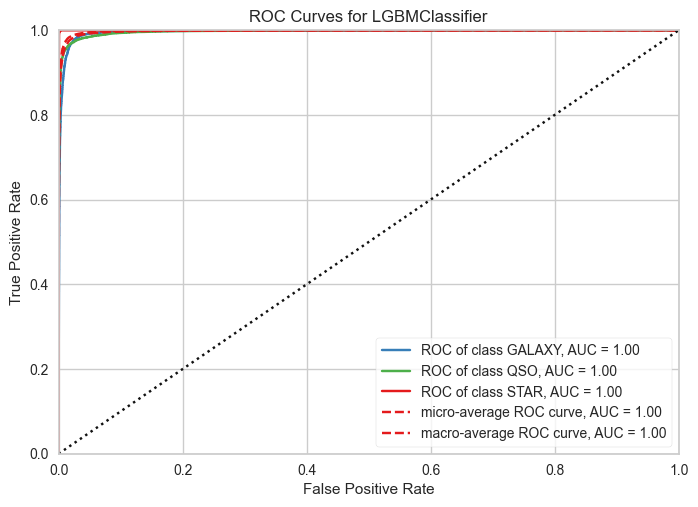

<Axes: title={'center': 'ROC Curves for LGBMClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [404]:
roc_lgbm = ROCAUC(lgbm, classes=classes)
set_palette('bold')
roc_lgbm.fit(X_train, y_train)        
roc_lgbm.score(X_test, y_test)       
roc_lgbm.show() 

In [405]:
param_dist = {
    'subsample': [0.2, 0.7, 0.8, 0.9],
    'num_leaves': [20, 31],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [4, 5, 6, 10, 13],
    'learning_rate': [ 0.01, 0.1, 0.4],
    'colsample_bytree': [0.4, 0.7, 0.8, 0.9]



}

random_search_lgbm = RandomizedSearchCV(estimator=lgbm, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 124834, number of used features: 6
[LightGBM] [Info] Start training from score -1.099654
[LightGBM] [Info] Start training from score -1.093036
[LightGBM] [Info] Start training from score -1.103173


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.4, 0.7, 0.8,
                                                             0.9],
                                        'learning_rate': [0.01, 0.1, 0.4],
                                        'max_depth': [4, 5, 6, 10, 13],
                                        'n_estimators': [50, 100, 150, 200],
                                        'num_leaves': [20, 31],
                                        'subsample': [0.2, 0.7, 0.8, 0.9]},
                   random_state=42)

In [406]:
print("Best Estimator:", random_search_lgbm.best_estimator_)
print("Best Parameters LGBM:", random_search_lgbm.best_params_)

Best Estimator: LGBMClassifier(colsample_bytree=0.9, max_depth=10, n_estimators=200,
               random_state=42, subsample=0.2)
Best Parameters LGBM: {'subsample': 0.2, 'num_leaves': 31, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 124834, number of used features: 6
[LightGBM] [Info] Start training from score -1.099654
[LightGBM] [Info] Start training from score -1.093036
[LightGBM] [Info] Start training from score -1.103173


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
0.9773462178277041
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     17877
           1       0.98      0.96      0.97     17601
           2       1.00      1.00      1.00     18023

    accuracy                           0.98     53501
   macro avg       0.98      0.98      0.98     53501
weighted avg       0.98      0.98      0.98     53501

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Accuracy using LGBMClassifier (Tuned): 0.9773462178277041


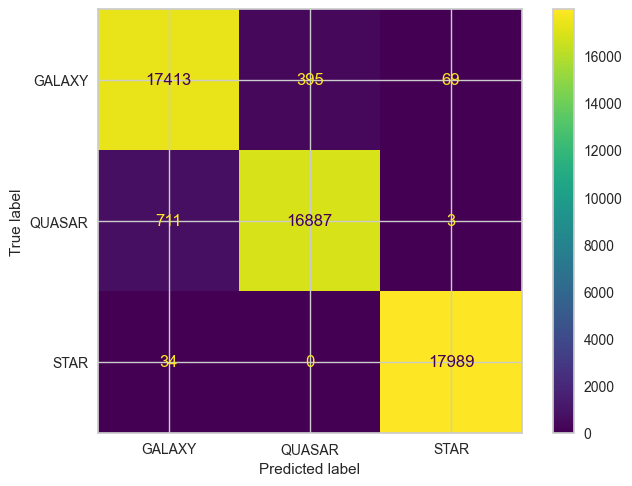

In [407]:
best_lgbm_model = random_search_lgbm.best_estimator_
best_lgbm_model.get_params
best_lgbm_model.fit(X_train, y_train)
y_predict = best_lgbm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_predict)
print(accuracy)

ConfusionMatrixDisplay.from_predictions(y_test, y_predict, 
                                        display_labels = ['GALAXY', 'QUASAR', 'STAR'])

cr1 = classification_report(y_test, y_predict)
print(cr1)
accuracy_best_lgbm_model = best_lgbm_model.score(X_test, y_test)
print("Accuracy using LGBMClassifier (Tuned):", accuracy_best_lgbm_model)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


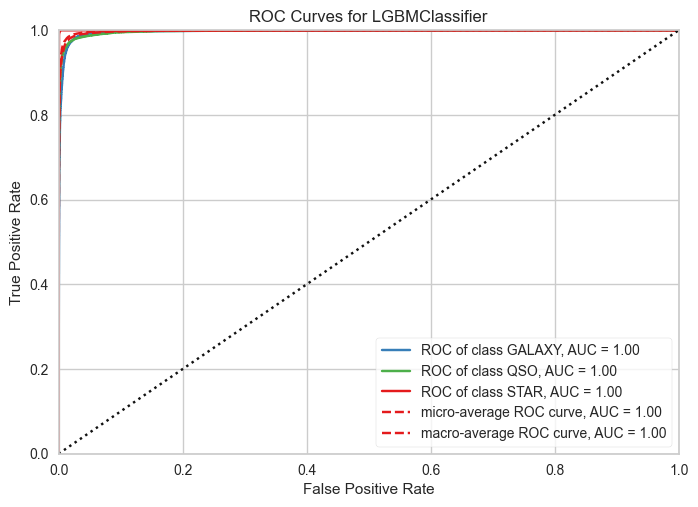

<Axes: title={'center': 'ROC Curves for LGBMClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [408]:
roc_lgbm_tuned = ROCAUC(best_lgbm_model, classes=classes)
set_palette('bold')
roc_lgbm_tuned.fit(X_train, y_train)        
roc_lgbm_tuned.score(X_test, y_test)       
roc_lgbm_tuned.show() 

In the case of LightBGMClassifier, the primary model has given the best accuracy. 

In [409]:
print("Accuracy using Random Forest Classifier(random_state=42):", accuracy_rfc)
print("Accuracy using optimized (Tuned) RFC:", accuracy_best_rf_model)
print("Accuracy using Extra Trees Classifier(random_state=42):", accuracy_etc)
print("Accuracy using Extra Trees Classifier (Tuned):", accuracy_best_etc_model)
print("Accuracy using Bagging Classifier(random_state=42):", accuracy_bc)
print("Accuracy using Bagging Classifier (Tuned):", accuracy_best_bc_model)
print("Accuracy using MLPClassifier (random_state=42):", accuracy_mlp)
print("Accuracy using MLP Classifier (Tuned):", accuracy_best_mlp_model)
print("Accuracy using XGBClassifier (random_state=42):", accuracy_xgb)
print("Accuracy using XGBClassifier (Tuned):", accuracy_best_xgb_model)
print("Accuracy using LGBM Classifier(random_state=42):", accuracy_lgbm)
print("Accuracy using LGBMClassifier (Tuned):", accuracy_best_lgbm_model)

Accuracy using Random Forest Classifier(random_state=42): 0.9820190276817256
Accuracy using optimized (Tuned) RFC: 0.9828975159342817
Accuracy using Extra Trees Classifier(random_state=42): 0.9824676174277116
Accuracy using Extra Trees Classifier (Tuned): 0.9818694977663969
Accuracy using Bagging Classifier(random_state=42): 0.9800190650642044
Accuracy using Extra Trees Classifier (Tuned): 0.9796826227547148
Accuracy using MLPClassifier (random_state=42): 0.9728977028466758
Accuracy using MLP Classifier (Tuned): 0.9715706248481337
Accuracy using XGBClassifier (random_state=42): 0.9782620885590924
Accuracy using XGBClassifier (Tuned): 0.9765238032933964
Accuracy using LGBM Classifier(random_state=42): 0.9757013887590886
Accuracy using LGBMClassifier (Tuned): 0.9773462178277041


In [410]:
print("Best Parameters RF:", random_search_rf.best_params_)
print("Best Parameters ETC:", random_search_etc.best_params_)
print("Best Parameters BC:", random_search_bc.best_params_)
print("Best Parameters MLP:", random_search_mlp.best_params_)
print("Best Parameters XGB:", random_search_xgb.best_params_)
print("Best Parameters LGBM:", random_search_lgbm.best_params_)

Best Parameters RF: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 50, 'bootstrap': False}
Best Parameters ETC: {'warm_start': False, 'n_estimators': 50, 'max_features': 'sqrt', 'max_depth': 32, 'bootstrap': False}
Best Parameters BC: {'warm_start': True, 'oob_score': False, 'n_estimators': 50, 'max_samples': 0.5, 'max_features': 0.92, 'bootstrap_features': False, 'bootstrap': True}
Best Parameters MLP: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (10, 30, 10), 'alpha': 0.0001, 'activation': 'relu'}
Best Parameters XGB: {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 0.5, 'max_depth': 5, 'learning_rate': 0.3, 'gamma': 0.0, 'colsample_bytree': 0.5}
Best Parameters LGBM: {'subsample': 0.2, 'num_leaves': 31, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


Now we will use the best six machine learning techniques (aacording to accuracy) with different effective combination to build our ensemble. We will use voting classifier to increse our accuracy. We check both the soft and hard voting method.

Voting Type: soft


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 124834, number of used features: 6
[LightGBM] [Info] Start training from score -1.099654
[LightGBM] [Info] Start training from score -1.093036
[LightGBM] [Info] Start training from score -1.103173
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Accuracy using Ensemble (Voting Classifier - soft): 0.9807293321620156
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2

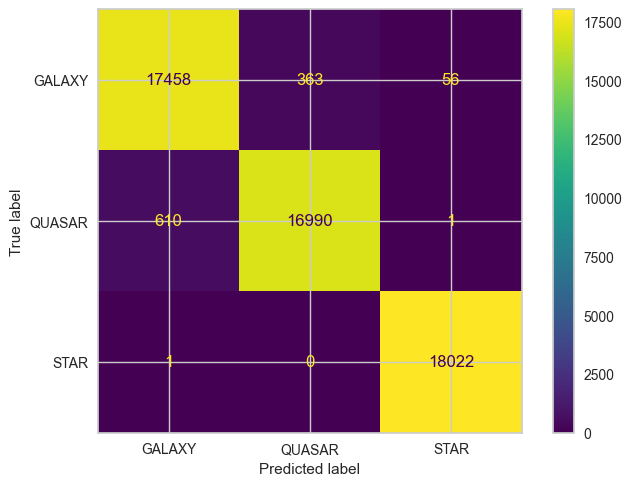

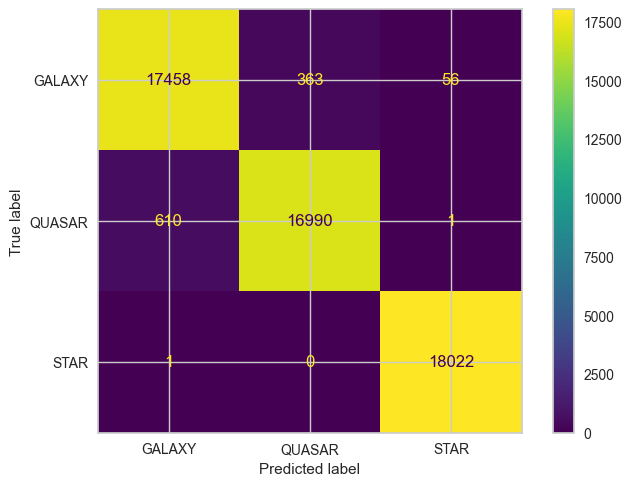

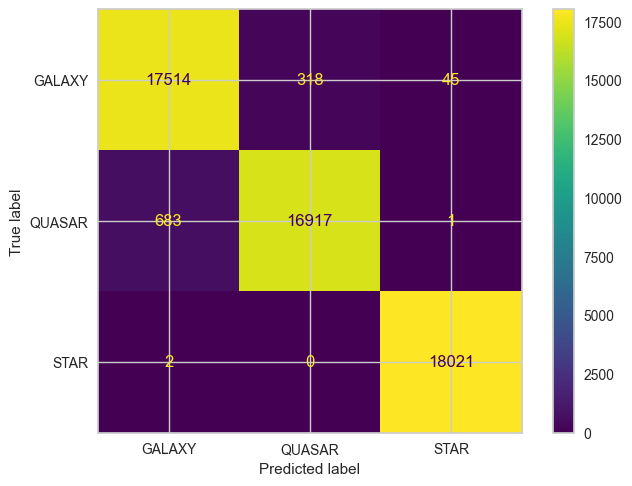

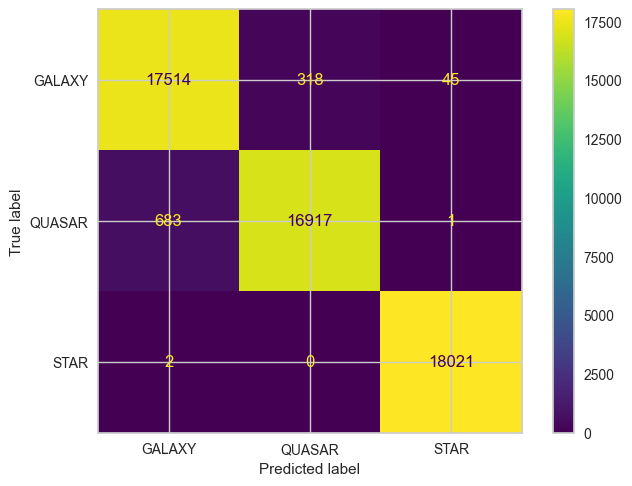

In [411]:
from sklearn.ensemble import VotingClassifier



# Create an initial ensemble with all models
initial_models = [
    ('rfc', best_rf_model),
    ('etc', etc),
    ('bc', bc),
    ('xgb', xgb),
    ('lgbm', best_lgbm_model),
    ('mlp', mlp)
]

# List to store results for 'soft' and 'hard' voting
voting_types = ['soft', 'hard']

for voting_type in voting_types:
    print(f"Voting Type: {voting_type}")
    
    # Create the ensemble model with the specified voting type
    ensemble_model = VotingClassifier(estimators=initial_models, voting=voting_type)
    ensemble_model.fit(X_train, y_train)

    # Predict using the ensemble model
    y_pred = ensemble_model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy using Ensemble (Voting Classifier - {voting_type}): {accuracy}")

    # Display confusion matrix
    ConfusionMatrixDisplay.from_estimator(ensemble_model, X_test, y_test, display_labels=['GALAXY', 'QUASAR', 'STAR']).plot()

    # Generate classification report
    cr = classification_report(y_test, y_pred)
    print(cr)

    # Calculate accuracy using ensemble's built-in score method
    accuracy_ensemble = ensemble_model.score(X_test, y_test)
    print(f"Accuracy using Ensemble's score method (Voting Classifier - {voting_type}): {accuracy_ensemble}")


    print("=" * 40)


Voting Type: soft
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 124834, number of used features: 6
[LightGBM] [Info] Start training from score -1.099654
[LightGBM] [Info] Start training from score -1.093036
[LightGBM] [Info] Start training from score -1.103173
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Accuracy using Ensemble (Voting Classifier - soft): 0.9816825853722361
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly s

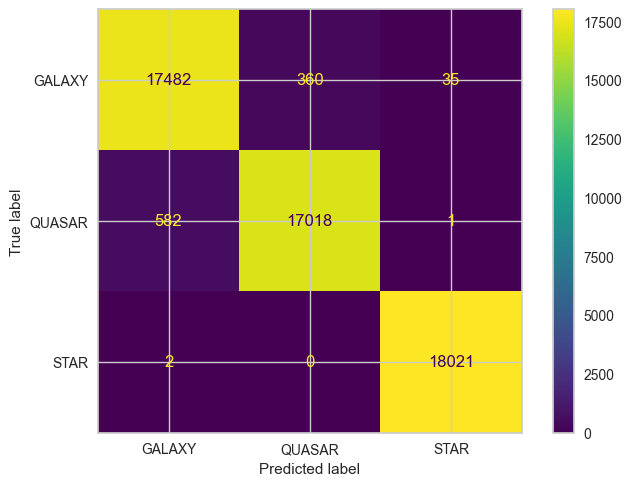

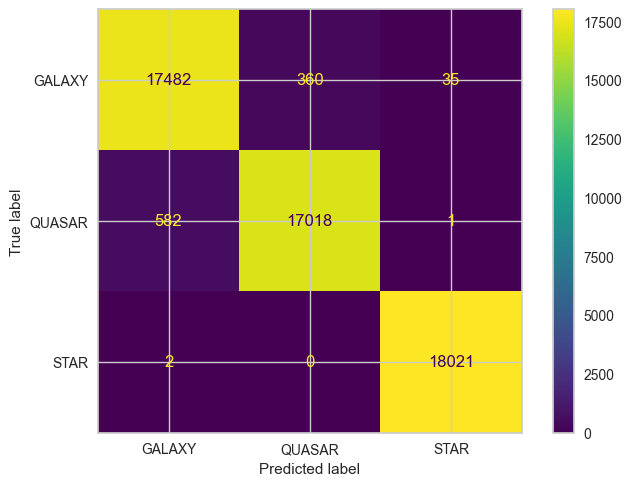

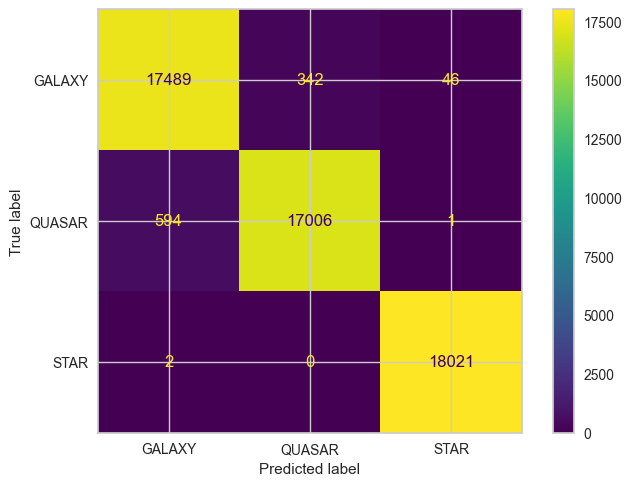

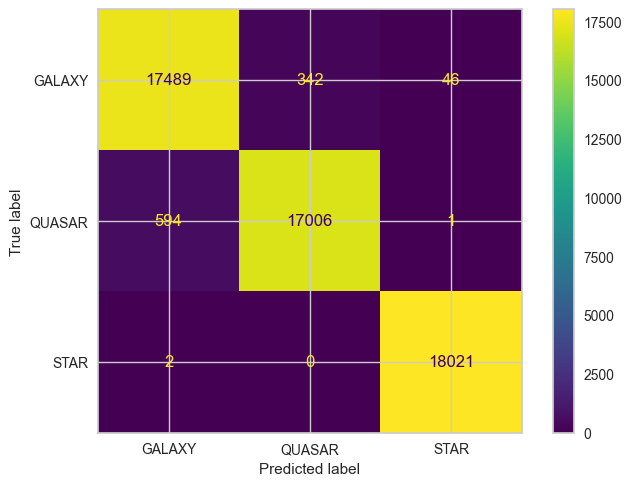

In [412]:
from sklearn.ensemble import VotingClassifier

# Create an initial ensemble with all models
initial_models = [
    ('rfc', best_rf_model),
    ('etc', etc),
    ('bc', bc),
    ('xgb', xgb),
    ('lgbm', best_lgbm_model)
]

# List to store results for 'soft' and 'hard' voting
voting_types = ['soft', 'hard']

for voting_type in voting_types:
    print(f"Voting Type: {voting_type}")
    
    # Create the ensemble model with the specified voting type
    ensemble_model = VotingClassifier(estimators=initial_models, voting=voting_type)
    ensemble_model.fit(X_train, y_train)

    # Predict using the ensemble model
    y_pred = ensemble_model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy using Ensemble (Voting Classifier - {voting_type}): {accuracy}")

    # Display confusion matrix
    ConfusionMatrixDisplay.from_estimator(ensemble_model, X_test, y_test, display_labels=['GALAXY', 'QUASAR', 'STAR']).plot()

    # Generate classification report
    cr = classification_report(y_test, y_pred)
    print(cr)

    # Calculate accuracy using ensemble's built-in score method
    accuracy_ensemble = ensemble_model.score(X_test, y_test)
    print(f"Accuracy using Ensemble's score method (Voting Classifier - {voting_type}): {accuracy_ensemble}")

    
    print("=" * 40)


Voting Type: soft
Accuracy using Ensemble (Voting Classifier - soft): 0.9826171473430403
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     17877
           1       0.98      0.97      0.97     17601
           2       1.00      1.00      1.00     18023

    accuracy                           0.98     53501
   macro avg       0.98      0.98      0.98     53501
weighted avg       0.98      0.98      0.98     53501

Accuracy using Ensemble's score method (Voting Classifier - soft): 0.9826171473430403
Voting Type: hard
Accuracy using Ensemble (Voting Classifier - hard): 0.982336778751799
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     17877
           1       0.98      0.96      0.97     17601
           2       1.00      1.00      1.00     18023

    accuracy                           0.98     53501
   macro avg       0.98      0.98      0.98     53501
weighted avg       0.98      0

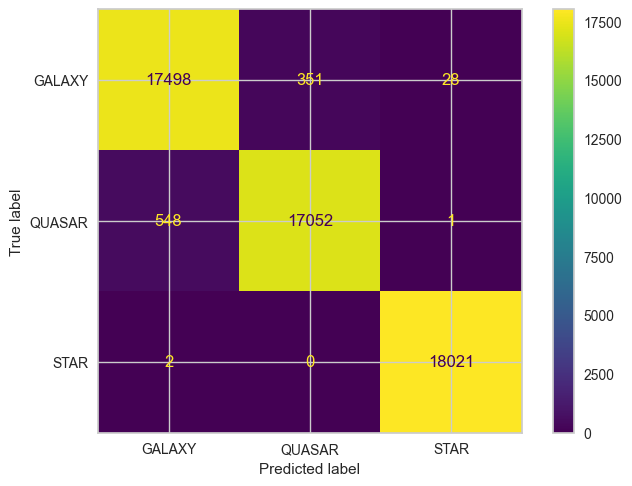

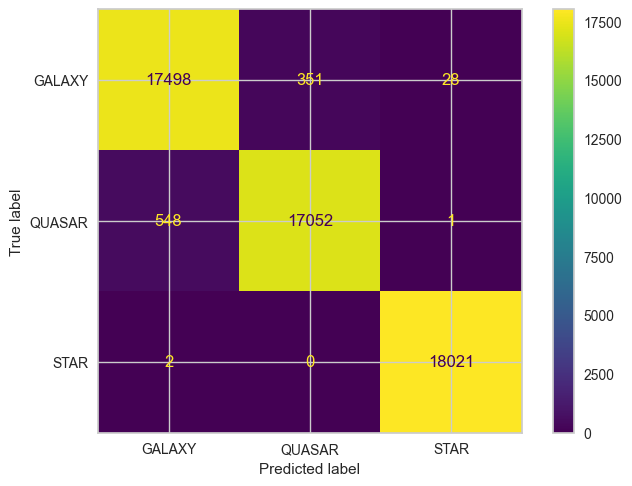

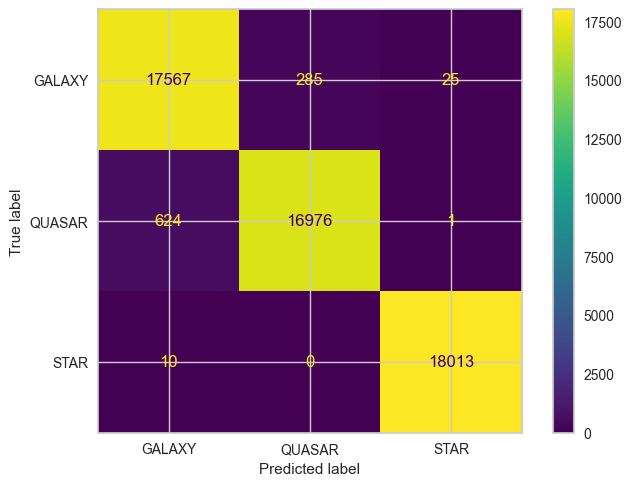

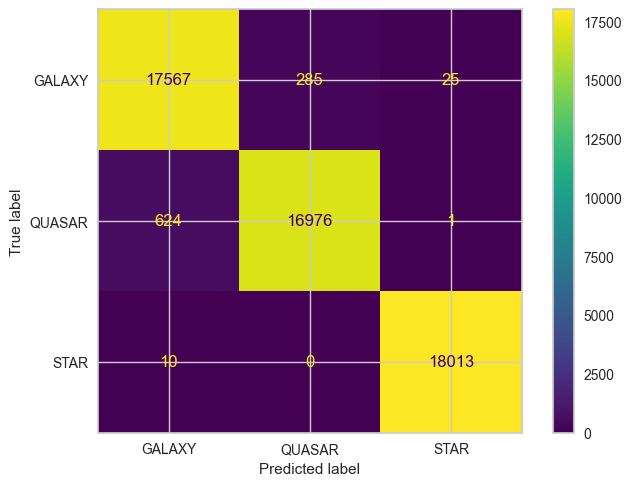

In [413]:

# Define the list of models and their corresponding names
# Create an initial ensemble with all models
initial_models = [
    ('rfc', best_rf_model),
    ('etc', etc),
    ('bc', bc),
    ('xgb', xgb)
]

# List to store results for 'soft' and 'hard' voting
voting_types = ['soft', 'hard']

for voting_type in voting_types:
    print(f"Voting Type: {voting_type}")
    
    # Create the ensemble model with the specified voting type
    ensemble_model = VotingClassifier(estimators=initial_models, voting=voting_type)
    ensemble_model.fit(X_train, y_train)

    # Predict using the ensemble model
    y_pred = ensemble_model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy using Ensemble (Voting Classifier - {voting_type}): {accuracy}")

    # Display confusion matrix
    ConfusionMatrixDisplay.from_estimator(ensemble_model, X_test, y_test, display_labels=['GALAXY', 'QUASAR', 'STAR']).plot()

    # Generate classification report
    cr = classification_report(y_test, y_pred)
    print(cr)

    # Calculate accuracy using ensemble's built-in score method
    accuracy_ensemble = ensemble_model.score(X_test, y_test)
    print(f"Accuracy using Ensemble's score method (Voting Classifier - {voting_type}): {accuracy_ensemble}")

    

    print("=" * 40)


Voting Type: soft
Accuracy using Ensemble (Voting Classifier - soft): 0.9832339582437711
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     17877
           1       0.98      0.97      0.98     17601
           2       1.00      1.00      1.00     18023

    accuracy                           0.98     53501
   macro avg       0.98      0.98      0.98     53501
weighted avg       0.98      0.98      0.98     53501

Accuracy using Ensemble's score method (Voting Classifier - soft): 0.9832339582437711
Voting Type: hard
Accuracy using Ensemble (Voting Classifier - hard): 0.983439561877348
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     17877
           1       0.98      0.97      0.98     17601
           2       1.00      1.00      1.00     18023

    accuracy                           0.98     53501
   macro avg       0.98      0.98      0.98     53501
weighted avg       0.98      0

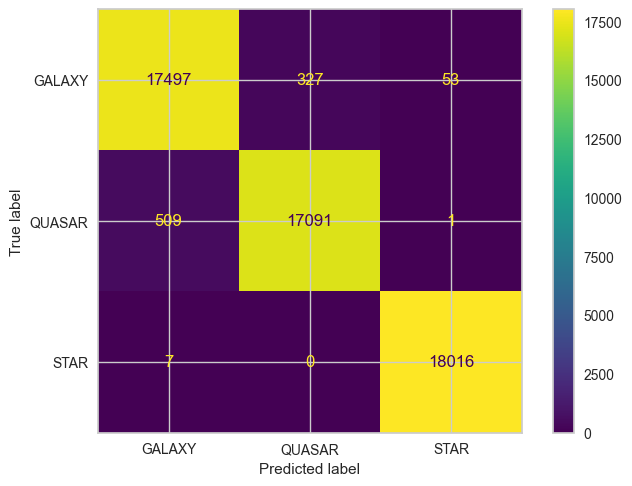

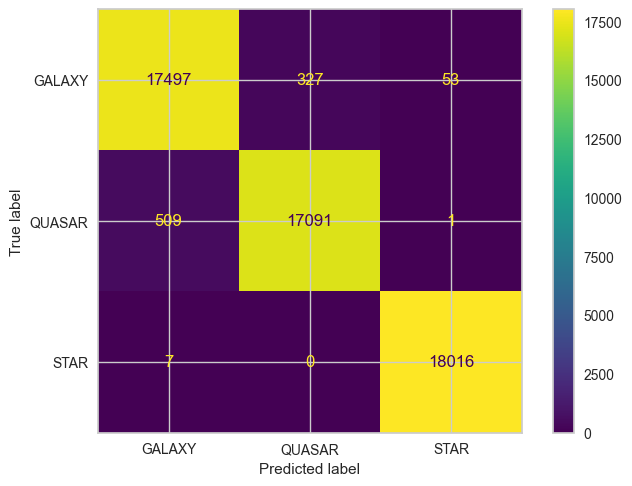

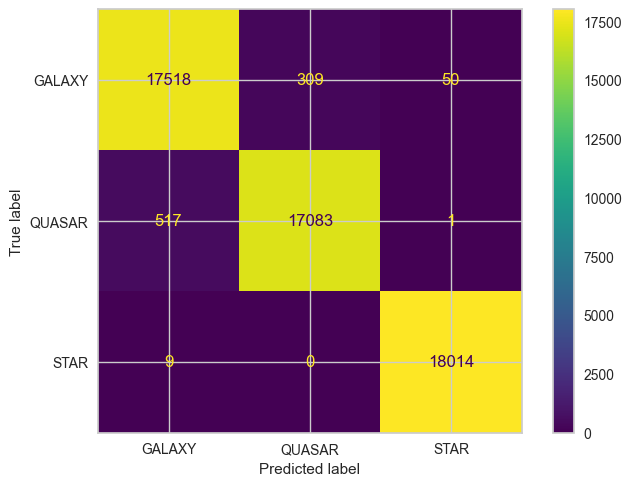

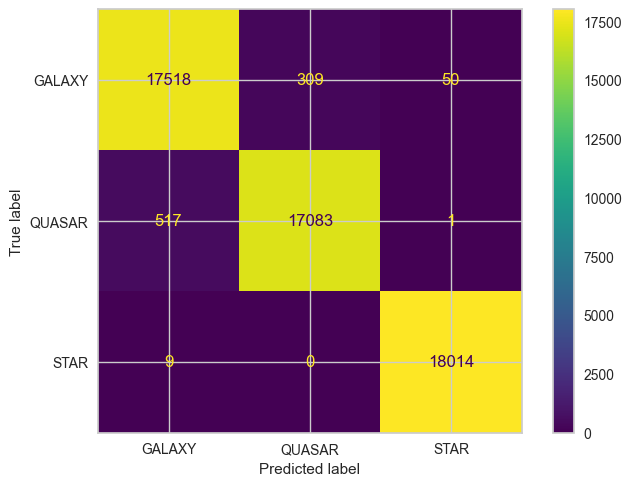

In [414]:
# Define the list of models and their corresponding names
# Create an initial ensemble with all models
initial_models = [
    ('rfc', best_rf_model),
    ('etc', etc),
    ('bc', bc)
]

# List to store results for 'soft' and 'hard' voting
voting_types = ['soft', 'hard']

for voting_type in voting_types:
    print(f"Voting Type: {voting_type}")
    
    # Create the ensemble model with the specified voting type
    ensemble_model = VotingClassifier(estimators=initial_models, voting=voting_type)
    ensemble_model.fit(X_train, y_train)

    # Predict using the ensemble model
    y_pred = ensemble_model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy using Ensemble (Voting Classifier - {voting_type}): {accuracy}")

    # Display confusion matrix
    ConfusionMatrixDisplay.from_estimator(ensemble_model, X_test, y_test, display_labels=['GALAXY', 'QUASAR', 'STAR']).plot()

    # Generate classification report
    cr = classification_report(y_test, y_pred)
    print(cr)

    # Calculate accuracy using ensemble's built-in score method
    accuracy_ensemble = ensemble_model.score(X_test, y_test)
    print(f"Accuracy using Ensemble's score method (Voting Classifier - {voting_type}): {accuracy_ensemble}")

    
    print("=" * 40)


Voting Type: soft
Accuracy using Ensemble (Voting Classifier - soft): 0.982766677258369
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     17877
           1       0.98      0.97      0.98     17601
           2       0.99      1.00      1.00     18023

    accuracy                           0.98     53501
   macro avg       0.98      0.98      0.98     53501
weighted avg       0.98      0.98      0.98     53501

Accuracy using Ensemble's score method (Voting Classifier - soft): 0.982766677258369
Voting Type: hard
Accuracy using Ensemble (Voting Classifier - hard): 0.9835704005532607
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     17877
           1       0.99      0.97      0.98     17601
           2       1.00      1.00      1.00     18023

    accuracy                           0.98     53501
   macro avg       0.98      0.98      0.98     53501
weighted avg       0.98      0.

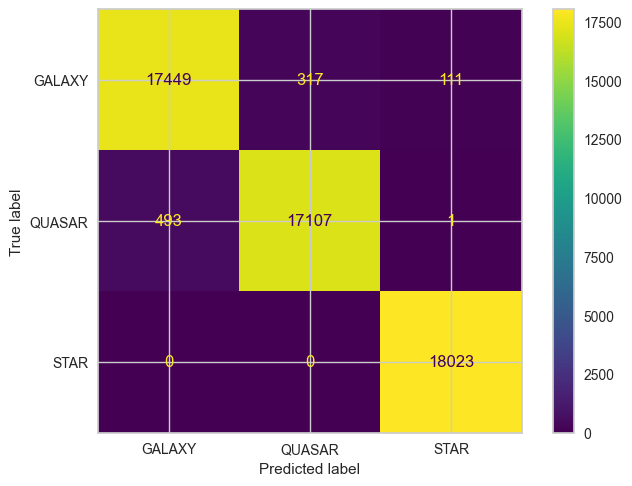

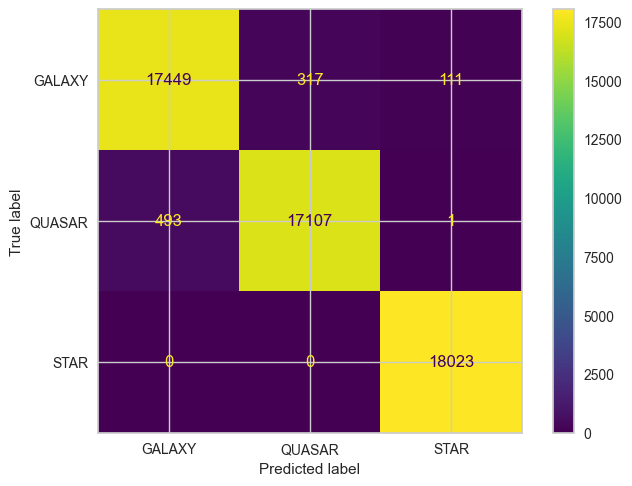

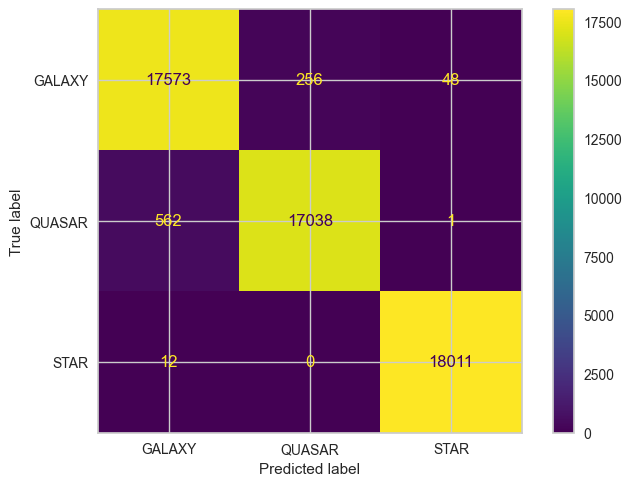

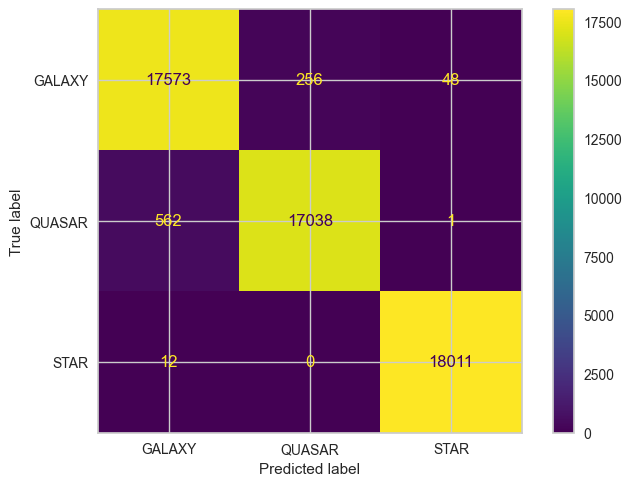

In [415]:
# Define the list of models and their corresponding names
# Create an initial ensemble with all models
initial_models = [
    ('rfc', best_rf_model),
    ('etc', etc)
]

# List to store results for 'soft' and 'hard' voting
voting_types = ['soft', 'hard']

for voting_type in voting_types:
    print(f"Voting Type: {voting_type}")
    
    # Create the ensemble model with the specified voting type
    ensemble_model = VotingClassifier(estimators=initial_models, voting=voting_type)
    ensemble_model.fit(X_train, y_train)

    # Predict using the ensemble model
    y_pred = ensemble_model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy using Ensemble (Voting Classifier - {voting_type}): {accuracy}")

    # Display confusion matrix
    ConfusionMatrixDisplay.from_estimator(ensemble_model, X_test, y_test, display_labels=['GALAXY', 'QUASAR', 'STAR']).plot()

    # Generate classification report
    cr = classification_report(y_test, y_pred)
    print(cr)

    # Calculate accuracy using ensemble's built-in score method
    accuracy_ensemble = ensemble_model.score(X_test, y_test)
    print(f"Accuracy using Ensemble's score method (Voting Classifier - {voting_type}): {accuracy_ensemble}")

    

    print("=" * 40)
